In [1]:
import numpy as np
import pandas as pd
from collections import defaultdict
from surprise import Dataset, Reader, accuracy
from surprise.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from surprise.model_selection import KFold
from tqdm.notebook import tqdm
from sklearn.metrics import ndcg_score
from surprise import dump
import seaborn as sns
import matplotlib.pyplot as plt
from typing import List
from surprise import SVD
import random
import pickle
from copy import deepcopy

import typing as tp
from sklearn.preprocessing import normalize
from lightfm import LightFM
from scipy.sparse import coo_matrix
from lightfm.data import Dataset as LFMDataset
from collections import Counter
from matplotlib.lines import Line2D
import time
import optuna

from sklearn.preprocessing import normalize
np.random.seed(42)

C:\ProgramData\Anaconda3\envs\torchvision2\lib\site-packages\lightfm\_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn(


In [2]:
from uuu import mapk_plot, mapk, calculate_serendipity_per_user, prediction_coverage, \
catalog_coverage, long_tail_plot, weight_by_volume, get_frame_from_prediction_list, novelty, get_value_popularity_ranks

In [3]:
df = pd.read_csv('../data/recsys-in-practice/train_joke_df.csv')

df['UID'] = df['UID'] - 1
df['JID'] = df['JID'] - 1
# сделаем сортировку и перепишем index
df = df.sort_values(by=['UID', 'JID'])
df = df.reset_index(drop=True)

df

df_train, df_test = train_test_split(df, test_size=0.5, random_state=42)

E:\competitions\kaggle\magnit_recsys-in-practice\part2\uuu.py:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  head = head.append(tail.head(1))


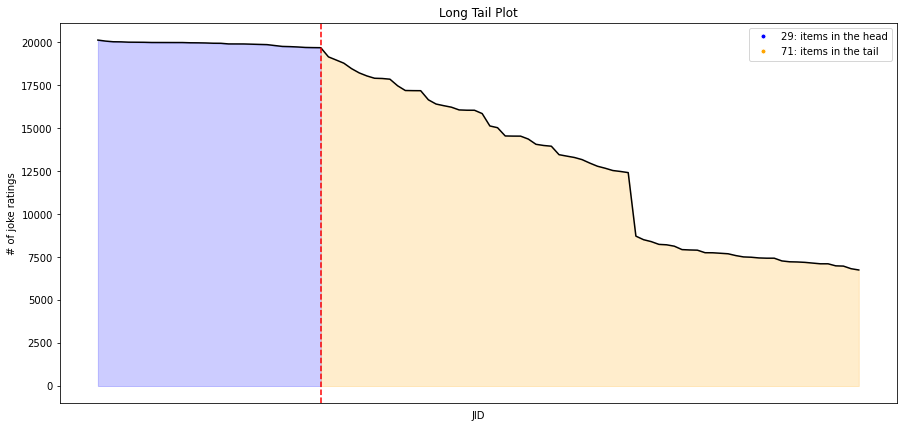

In [4]:
fig = plt.figure(figsize=(15, 7))
volume_df = long_tail_plot(df=df, 
             item_id_column="JID", 
             interaction_type="joke ratings", 
             percentage=0.4,
             x_labels=False)

volume_df['weight'] = volume_df['percent_of_total_volume'].apply(weight_by_volume)
joke_volume = {}
for row in volume_df.itertuples():
    joke_volume[int(row.JID)] = row.weight

In [5]:
df_top_joke = df[df['Rating'] > 5].groupby('JID').agg('count').rename(columns={'Rating':'count_plus'}) \
.sort_values('count_plus', ascending=False).drop(columns=['UID'])


df_bottom_joke = df[df['Rating'] < -5].groupby('JID').agg('count').rename(columns={'Rating':'count_minus'}) \
.sort_values('count_minus', ascending=False).drop(columns=['UID'])


df_counts = df_bottom_joke.merge(df_top_joke, left_index=True, right_index=True)


df_counts['diff'] = df_counts['count_plus'] - df_counts['count_minus']
df_counts = df_counts.sort_values('diff', ascending=False)


df_counts['weight'] = df_counts['diff'] / 10000

joke_quality = {}
for row in df_counts.itertuples():
    joke_quality[row.Index] = row.weight

In [6]:

from CatBoostWrapper import CatBoostWrapper
from LightFMWrapper import LightFMWrapper
from NNWrapper import NNWrapper
from SurpriseWrapper import SurpriseWrapper


In [7]:

wrappers ={
    'svd':SurpriseWrapper(model_name='svd05.surprise', folder_name='models', df_train=df_train), 
    'lfm_cos':LightFMWrapper(model_name='', folder_name='models', df_train=df_train),           
    'catboost':CatBoostWrapper(model_name='catboost05', folder_name='models', df_train=df_train), 
    'knn':SurpriseWrapper(model_name='knn05.surprise', folder_name='models', df_train=df_train), 
    'nn_bias':NNWrapper(model_name='nn05.ckpt', folder_name='models', df_train=df_train)
}


In [8]:

candidates = {model_name: wrapper.predict() for model_name, wrapper in wrappers.items()}
    

svd05.surprise time: 59.376
lightfm time: 32.528
catboost05 time: 49.337
knn05.surprise time: 114.341
nn05.ckpt time: 59.593


In [9]:
predictions = {k:list(v.groupby('UID').agg({'JID':list})['JID'].values) for k, v in candidates.items()}

In [10]:
n_users = np.unique(df['UID']).size
n_items = np.unique(df['JID']).size
n_recommendations=10

In [11]:
def get_n_recommendations_for_user(df, user_id, n, sort_by):
    recommended_items = df[df['UID'] == user_id]
    recommended_items = recommended_items.sort_values(sort_by, ascending=False)  
    return recommended_items.iloc[:n]


frames = []
for user in tqdm(range(n_users)):
    frames.append(get_n_recommendations_for_user(df_test, user, n_recommendations, 'Rating'))
    
df_true = pd.concat(frames).reset_index()
df_true = df_true.drop(columns=['index'])
display(df_true)

actual = list(df_true.groupby('UID').agg({'JID':list})['JID'].values)

  0%|          | 0/24983 [00:00<?, ?it/s]

,UID,JID,Rating
0,0,1,8.79
1,0,13,8.45
2,0,26,7.82
3,0,7,4.17
4,0,61,3.59
...,...,...,...
249691,24982,20,7.28
249692,24982,24,6.94
249693,24982,48,6.84
249694,24982,54,6.36


In [12]:
users = df["UID"].unique()
n_users = users.size
n_users

24983

In [13]:
# рекомендации по популярным 
#popularity_recs = df['JID'].value_counts().head(10).index.tolist()

#pop_recs = []
#for user in tqdm(range(n_users)):
#    pop_predictions = popularity_recs
#    pop_recs.append(pop_predictions)
    
    
#predictions['popular'] = pop_recs

In [14]:
pop = dict(df.JID.value_counts())

In [15]:
items = np.unique(df['JID'])
items

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99],
      dtype=int64)

In [16]:
xx = {k:(v, joke_volume[k]) for k, v in joke_quality.items() if v > 0.1 and joke_volume[k] > 0.1}
len(xx), xx

(37,
 {49: (0.7776, 0.3),
  35: (0.6984, 0.4),
  26: (0.6943, 0.3),
  61: (0.635, 0.2),
  34: (0.6339, 0.2),
  28: (0.6309, 0.4),
  53: (0.5896, 0.5),
  67: (0.544, 0.3),
  68: (0.5351, 0.2),
  65: (0.5227, 0.2),
  60: (0.5155, 0.3),
  64: (0.4917, 0.4),
  30: (0.4617, 0.4),
  41: (0.4023, 0.4),
  47: (0.3671, 0.4),
  55: (0.3436, 0.4),
  10: (0.3328, 0.5),
  27: (0.3065, 0.5),
  45: (0.2814, 0.5),
  46: (0.2788, 0.5),
  13: (0.2594, 0.5),
  5: (0.2585, 0.5),
  11: (0.2572, 0.5),
  25: (0.2338, 0.5),
  37: (0.2322, 0.5),
  9: (0.2105, 0.4),
  92: (0.1965, 0.2),
  38: (0.1899, 0.5),
  39: (0.1873, 0.5),
  44: (0.1776, 0.5),
  90: (0.1622, 0.2),
  33: (0.1564, 0.5),
  21: (0.1552, 0.5),
  96: (0.1372, 0.2),
  95: (0.1155, 0.2),
  99: (0.1084, 0.2),
  0: (0.1044, 0.3)})

In [17]:
random.choices(list(xx.keys()), k=10)

[5, 25, 10, 95, 65, 68, 37, 45, 47, 92]

In [18]:
def union_predicts2(params):
    result = []

    for u in range(24983):
        result.append(random.choices(list(xx.keys()), k=10))
        
    return result

In [19]:
def union_predicts(params):
    result = []

    for u in range(24983):
        res = {}
                    
        for k in range(100):
            if joke_quality[k] < 0.00:# or joke_volume[k] < 0.1:
                continue
            res[k] = joke_quality[k] * params['quality']
            res[k] += joke_volume[k] * params['volume']

        xx = np.array(
            [[x[0], x[1]] for x in sorted(res.items(), key=lambda item: item[1], reverse=True)])
        
        #print(xx.shape)
        pp = xx[:, 1]
        pp += np.abs(np.min(pp))
        result.append(np.random.choice(xx[:, 0], size=10, replace=False, p=pp/np.sum(pp)))
        
    return result#, xx, pp/np.sum(pp)

In [22]:
def main_metric(params):
    t1 = time.time()
    result = union_predicts(params)
    res_df = get_frame_from_prediction_list(users, result)


    cat_coverage = catalog_coverage(result, items, 100)
    pred_coverage = prediction_coverage(result, items)
    nov, mselfinfo_list = novelty(result, pop, len(users), 10)

    res_df = get_frame_from_prediction_list(users, result)
    serendip = calculate_serendipity_per_user(res_df, df_train, df_test)
    map1 = mapk(actual, result, k=1)
    map10 = mapk(actual, result, k=10)
    
    price = np.mean([sum([joke_volume[x] for x in xx]) for xx in result])
    
    sm = sum([cat_coverage / 100, pred_coverage / 100, nov, serendip, map1, map10, price / 3])
    print('time',round(time.time() - t1, 3), 
        'cat_cov',  round(cat_coverage, 3), 
         'cov', round(pred_coverage, 3),
         'nov', round(nov, 3),
         'ser', round(serendip, 3),
        'm1',  round(map1 , 3),
         'm10', round(map10, 3),
         'price', round(price, 3),
         'sum', round(sm, 3))
    return sm

In [23]:
main_metric({
              'quality': 1,
              'volume': 1
             })

time 6.276 cat_cov 70.0 cov 70.0 nov 0.699 ser 0.086 m1 0.145 m10 0.287 price 3.284 sum 3.711


3.710801491721396

In [24]:
def objective(trial):    
    
    params = {
              'quality': trial.suggest_float(name='quality', low=-1, high=1, step=0.1),
              'volume': trial.suggest_float(name='volume', low=-1, high=1, step=0.1)
             }
    
    return main_metric(params)
    


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=1000)


[I 2023-05-12 13:34:05,080] A new study created in memory with name: no-name-58ecff74-5a4f-427f-9f1a-40f051e509a5
[I 2023-05-12 13:34:11,284] Trial 0 finished with value: 3.5762712971213717 and parameters: {'quality': 0.5, 'volume': -0.8}. Best is trial 0 with value: 3.5762712971213717.


time 6.2 cat_cov 69.0 cov 69.0 nov 0.976 ser 0.081 m1 0.129 m10 0.266 price 2.231 sum 3.576


[I 2023-05-12 13:34:17,472] Trial 1 finished with value: 3.7278162302526785 and parameters: {'quality': 0.20000000000000018, 'volume': 0.30000000000000004}. Best is trial 1 with value: 3.7278162302526785.


time 6.187 cat_cov 70.0 cov 70.0 nov 0.71 ser 0.087 m1 0.139 m10 0.281 price 3.329 sum 3.728


[I 2023-05-12 13:34:23,766] Trial 2 finished with value: 3.614539276999265 and parameters: {'quality': 0.6000000000000001, 'volume': 0.10000000000000009}. Best is trial 1 with value: 3.7278162302526785.


time 6.293 cat_cov 70.0 cov 70.0 nov 0.646 ser 0.075 m1 0.158 m10 0.305 price 3.092 sum 3.615


[I 2023-05-12 13:34:30,014] Trial 3 finished with value: 3.7262367584981937 and parameters: {'quality': 0.7000000000000002, 'volume': 0.9000000000000001}. Best is trial 1 with value: 3.7278162302526785.


time 6.247 cat_cov 70.0 cov 70.0 nov 0.706 ser 0.087 m1 0.145 m10 0.285 price 3.311 sum 3.726


[I 2023-05-12 13:34:36,188] Trial 4 finished with value: 3.7710827080227833 and parameters: {'quality': 0.20000000000000018, 'volume': 0.7000000000000002}. Best is trial 4 with value: 3.7710827080227833.


time 6.173 cat_cov 70.0 cov 70.0 nov 0.73 ser 0.092 m1 0.139 m10 0.276 price 3.4 sum 3.771


[I 2023-05-12 13:34:42,250] Trial 5 finished with value: 3.7715770266104154 and parameters: {'quality': -0.19999999999999996, 'volume': -0.09999999999999998}. Best is trial 5 with value: 3.7715770266104154.


time 6.06 cat_cov 68.0 cov 69.0 nov 1.137 ser 0.108 m1 0.089 m10 0.201 price 2.599 sum 3.772


[I 2023-05-12 13:34:48,468] Trial 6 finished with value: 3.71430906382595 and parameters: {'quality': 0.7000000000000002, 'volume': 0.8}. Best is trial 5 with value: 3.7715770266104154.


time 6.217 cat_cov 70.0 cov 70.0 nov 0.701 ser 0.086 m1 0.142 m10 0.285 price 3.299 sum 3.714


[I 2023-05-12 13:34:54,597] Trial 7 finished with value: 3.820171758037061 and parameters: {'quality': -0.8, 'volume': 0.9000000000000001}. Best is trial 7 with value: 3.820171758037061.


time 6.127 cat_cov 68.0 cov 69.0 nov 0.941 ser 0.107 m1 0.101 m10 0.224 price 3.232 sum 3.82


[I 2023-05-12 13:35:00,899] Trial 8 finished with value: 3.5989466108423613 and parameters: {'quality': 0.9000000000000001, 'volume': 0.10000000000000009}. Best is trial 7 with value: 3.820171758037061.


time 6.301 cat_cov 70.0 cov 70.0 nov 0.633 ser 0.073 m1 0.161 m10 0.308 price 3.075 sum 3.599


[I 2023-05-12 13:35:07,023] Trial 9 finished with value: 3.833791482710209 and parameters: {'quality': -0.19999999999999996, 'volume': 0.20000000000000018}. Best is trial 9 with value: 3.833791482710209.


time 6.123 cat_cov 69.0 cov 69.0 nov 0.956 ser 0.107 m1 0.1 m10 0.225 price 3.198 sum 3.834


[I 2023-05-12 13:35:13,158] Trial 10 finished with value: 3.7327877871951975 and parameters: {'quality': -0.5, 'volume': -0.6}. Best is trial 9 with value: 3.833791482710209.


time 6.127 cat_cov 68.0 cov 69.0 nov 1.193 ser 0.106 m1 0.085 m10 0.198 price 2.342 sum 3.733


[I 2023-05-12 13:35:19,352] Trial 11 finished with value: 3.8239046669138474 and parameters: {'quality': -1.0, 'volume': 0.5}. Best is trial 9 with value: 3.833791482710209.


time 6.188 cat_cov 68.0 cov 69.0 nov 1.022 ser 0.11 m1 0.097 m10 0.213 price 3.038 sum 3.824


[I 2023-05-12 13:35:25,483] Trial 12 finished with value: 3.81720002198598 and parameters: {'quality': -1.0, 'volume': 0.40000000000000013}. Best is trial 9 with value: 3.833791482710209.


time 6.124 cat_cov 68.0 cov 69.0 nov 1.033 ser 0.109 m1 0.093 m10 0.212 price 2.999 sum 3.817


[I 2023-05-12 13:35:31,548] Trial 13 finished with value: 3.772064970521671 and parameters: {'quality': -0.5, 'volume': -0.29999999999999993}. Best is trial 9 with value: 3.833791482710209.


time 6.059 cat_cov 69.0 cov 69.0 nov 1.15 ser 0.107 m1 0.086 m10 0.198 price 2.55 sum 3.772


[I 2023-05-12 13:35:37,718] Trial 14 finished with value: 3.8354430169219507 and parameters: {'quality': -0.19999999999999996, 'volume': 0.5}. Best is trial 14 with value: 3.8354430169219507.


time 6.163 cat_cov 68.0 cov 69.0 nov 0.835 ser 0.105 m1 0.115 m10 0.246 price 3.493 sum 3.835


[I 2023-05-12 13:35:43,904] Trial 15 finished with value: 3.832526344106297 and parameters: {'quality': -0.19999999999999996, 'volume': 0.5}. Best is trial 14 with value: 3.8354430169219507.


time 6.179 cat_cov 68.0 cov 69.0 nov 0.836 ser 0.104 m1 0.114 m10 0.244 price 3.492 sum 3.833


[I 2023-05-12 13:35:50,030] Trial 16 finished with value: 3.3018926816524745 and parameters: {'quality': 0.0, 'volume': -0.29999999999999993}. Best is trial 14 with value: 3.8354430169219507.


time 6.121 cat_cov 54.0 cov 54.0 nov 1.236 ser 0.092 m1 0.098 m10 0.218 price 1.734 sum 3.302


[I 2023-05-12 13:35:56,131] Trial 17 finished with value: 3.819255549202302 and parameters: {'quality': -0.5, 'volume': 0.20000000000000018}. Best is trial 14 with value: 3.8354430169219507.


time 6.093 cat_cov 68.0 cov 69.0 nov 1.034 ser 0.109 m1 0.095 m10 0.212 price 2.998 sum 3.819


[I 2023-05-12 13:36:02,261] Trial 18 finished with value: 3.7130926683271337 and parameters: {'quality': -0.09999999999999998, 'volume': -0.19999999999999996}. Best is trial 14 with value: 3.8354430169219507.


time 6.124 cat_cov 69.0 cov 69.0 nov 1.199 ser 0.102 m1 0.091 m10 0.204 price 2.212 sum 3.713


[I 2023-05-12 13:36:08,438] Trial 19 finished with value: 3.7406789678077965 and parameters: {'quality': 0.30000000000000004, 'volume': 0.6000000000000001}. Best is trial 14 with value: 3.8354430169219507.


time 6.171 cat_cov 70.0 cov 70.0 nov 0.719 ser 0.089 m1 0.138 m10 0.277 price 3.351 sum 3.741


[I 2023-05-12 13:36:14,549] Trial 20 finished with value: 3.7066082994477525 and parameters: {'quality': -0.29999999999999993, 'volume': -0.5}. Best is trial 14 with value: 3.8354430169219507.


time 6.104 cat_cov 68.0 cov 69.0 nov 1.194 ser 0.104 m1 0.086 m10 0.199 price 2.262 sum 3.707


[I 2023-05-12 13:36:20,743] Trial 21 finished with value: 3.8249010694110828 and parameters: {'quality': -0.29999999999999993, 'volume': 0.5}. Best is trial 14 with value: 3.8354430169219507.


time 6.188 cat_cov 68.0 cov 69.0 nov 0.892 ser 0.105 m1 0.107 m10 0.233 price 3.353 sum 3.825


[I 2023-05-12 13:36:26,981] Trial 22 finished with value: 3.7680455559036288 and parameters: {'quality': 0.10000000000000009, 'volume': 0.30000000000000004}. Best is trial 14 with value: 3.8354430169219507.


time 6.23 cat_cov 70.0 cov 70.0 nov 0.728 ser 0.091 m1 0.14 m10 0.279 price 3.389 sum 3.768


[I 2023-05-12 13:36:33,106] Trial 23 finished with value: 3.8329745916845614 and parameters: {'quality': -0.7, 'volume': 0.7000000000000002}. Best is trial 14 with value: 3.8354430169219507.


time 6.119 cat_cov 69.0 cov 69.0 nov 0.954 ser 0.107 m1 0.101 m10 0.224 price 3.202 sum 3.833


[I 2023-05-12 13:36:39,244] Trial 24 finished with value: 3.825145428664478 and parameters: {'quality': -0.8, 'volume': 0.8}. Best is trial 14 with value: 3.8354430169219507.


time 6.13 cat_cov 68.0 cov 69.0 nov 0.954 ser 0.108 m1 0.101 m10 0.224 price 3.204 sum 3.825


[I 2023-05-12 13:36:45,386] Trial 25 finished with value: 3.834339147971674 and parameters: {'quality': -0.7, 'volume': 0.7000000000000002}. Best is trial 14 with value: 3.8354430169219507.


time 6.136 cat_cov 69.0 cov 69.0 nov 0.954 ser 0.107 m1 0.101 m10 0.223 price 3.206 sum 3.834


[I 2023-05-12 13:36:51,573] Trial 26 finished with value: 3.8330508282935236 and parameters: {'quality': -0.6, 'volume': 1.0}. Best is trial 14 with value: 3.8354430169219507.


time 6.179 cat_cov 69.0 cov 69.0 nov 0.891 ser 0.106 m1 0.104 m10 0.233 price 3.36 sum 3.833


[I 2023-05-12 13:36:57,669] Trial 27 finished with value: 3.7997039484917066 and parameters: {'quality': -0.3999999999999999, 'volume': 0.0}. Best is trial 14 with value: 3.8354430169219507.


time 6.089 cat_cov 69.0 cov 69.0 nov 1.081 ser 0.109 m1 0.088 m10 0.203 price 2.815 sum 3.8


[I 2023-05-12 13:37:03,845] Trial 28 finished with value: 3.831770587401203 and parameters: {'quality': -0.09999999999999998, 'volume': 0.30000000000000004}. Best is trial 14 with value: 3.8354430169219507.


time 6.169 cat_cov 68.0 cov 69.0 nov 0.811 ser 0.104 m1 0.116 m10 0.248 price 3.549 sum 3.832


[I 2023-05-12 13:37:10,034] Trial 29 finished with value: 3.5647876978352913 and parameters: {'quality': 0.30000000000000004, 'volume': -1.0}. Best is trial 14 with value: 3.8354430169219507.


time 6.182 cat_cov 66.0 cov 69.0 nov 1.079 ser 0.086 m1 0.121 m10 0.25 price 2.038 sum 3.565


[I 2023-05-12 13:37:16,140] Trial 30 finished with value: 3.8347261329095312 and parameters: {'quality': -0.8, 'volume': 0.6000000000000001}. Best is trial 14 with value: 3.8354430169219507.


time 6.1 cat_cov 69.0 cov 69.0 nov 0.987 ser 0.108 m1 0.099 m10 0.219 price 3.126 sum 3.835


[I 2023-05-12 13:37:22,272] Trial 31 finished with value: 3.8379677168980155 and parameters: {'quality': -0.8, 'volume': 0.6000000000000001}. Best is trial 31 with value: 3.8379677168980155.


time 6.125 cat_cov 69.0 cov 69.0 nov 0.985 ser 0.108 m1 0.1 m10 0.222 price 3.127 sum 3.838


[I 2023-05-12 13:37:28,391] Trial 32 finished with value: 3.815545470797729 and parameters: {'quality': -0.8, 'volume': 0.6000000000000001}. Best is trial 31 with value: 3.8379677168980155.


time 6.113 cat_cov 67.0 cov 69.0 nov 0.982 ser 0.108 m1 0.101 m10 0.219 price 3.136 sum 3.816


[I 2023-05-12 13:37:34,574] Trial 33 finished with value: 3.8299039970699056 and parameters: {'quality': -0.9, 'volume': 1.0}. Best is trial 31 with value: 3.8379677168980155.


time 6.175 cat_cov 69.0 cov 69.0 nov 0.942 ser 0.106 m1 0.1 m10 0.224 price 3.23 sum 3.83


[I 2023-05-12 13:37:40,714] Trial 34 finished with value: 3.83868171549092 and parameters: {'quality': -0.7, 'volume': 0.7000000000000002}. Best is trial 34 with value: 3.83868171549092.


time 6.133 cat_cov 69.0 cov 69.0 nov 0.954 ser 0.108 m1 0.103 m10 0.226 price 3.204 sum 3.839


[I 2023-05-12 13:37:46,842] Trial 35 finished with value: 3.8086275161332255 and parameters: {'quality': -0.6, 'volume': 0.40000000000000013}. Best is trial 34 with value: 3.83868171549092.


time 6.122 cat_cov 67.0 cov 69.0 nov 0.997 ser 0.108 m1 0.095 m10 0.216 price 3.098 sum 3.809


[I 2023-05-12 13:37:52,985] Trial 36 finished with value: 3.8290473524306448 and parameters: {'quality': -0.9, 'volume': 0.8}. Best is trial 34 with value: 3.83868171549092.


time 6.135 cat_cov 68.0 cov 69.0 nov 0.967 ser 0.108 m1 0.102 m10 0.224 price 3.175 sum 3.829


[I 2023-05-12 13:37:59,154] Trial 37 finished with value: 3.823944881115456 and parameters: {'quality': -0.7, 'volume': 0.6000000000000001}. Best is trial 34 with value: 3.83868171549092.


time 6.162 cat_cov 68.0 cov 69.0 nov 0.971 ser 0.108 m1 0.1 m10 0.221 price 3.162 sum 3.824


[I 2023-05-12 13:38:05,282] Trial 38 finished with value: 3.8350825457580884 and parameters: {'quality': -1.0, 'volume': 0.9000000000000001}. Best is trial 34 with value: 3.83868171549092.


time 6.121 cat_cov 69.0 cov 69.0 nov 0.965 ser 0.108 m1 0.101 m10 0.223 price 3.176 sum 3.835


[I 2023-05-12 13:38:11,416] Trial 39 finished with value: 3.830572143296819 and parameters: {'quality': -1.0, 'volume': 1.0}. Best is trial 34 with value: 3.83868171549092.


time 6.128 cat_cov 69.0 cov 69.0 nov 0.953 ser 0.107 m1 0.1 m10 0.222 price 3.204 sum 3.831


[I 2023-05-12 13:38:17,665] Trial 40 finished with value: 3.737297444225215 and parameters: {'quality': 0.5, 'volume': 0.9000000000000001}. Best is trial 34 with value: 3.83868171549092.


time 6.242 cat_cov 70.0 cov 70.0 nov 0.717 ser 0.088 m1 0.139 m10 0.279 price 3.345 sum 3.737


[I 2023-05-12 13:38:23,805] Trial 41 finished with value: 3.8346742721242384 and parameters: {'quality': -0.8, 'volume': 0.7000000000000002}. Best is trial 34 with value: 3.83868171549092.


time 6.134 cat_cov 69.0 cov 69.0 nov 0.968 ser 0.108 m1 0.101 m10 0.222 price 3.17 sum 3.835


[I 2023-05-12 13:38:29,935] Trial 42 finished with value: 3.828945954756354 and parameters: {'quality': -0.9, 'volume': 0.8}. Best is trial 34 with value: 3.83868171549092.


time 6.124 cat_cov 68.0 cov 69.0 nov 0.967 ser 0.108 m1 0.104 m10 0.225 price 3.167 sum 3.829


[I 2023-05-12 13:38:36,089] Trial 43 finished with value: 3.8169881715254013 and parameters: {'quality': -0.6, 'volume': 0.40000000000000013}. Best is trial 34 with value: 3.83868171549092.


time 6.146 cat_cov 68.0 cov 69.0 nov 0.996 ser 0.108 m1 0.095 m10 0.216 price 3.099 sum 3.817


[I 2023-05-12 13:38:42,260] Trial 44 finished with value: 3.8370930023602 and parameters: {'quality': -1.0, 'volume': 0.9000000000000001}. Best is trial 34 with value: 3.83868171549092.


time 6.164 cat_cov 69.0 cov 69.0 nov 0.967 ser 0.108 m1 0.101 m10 0.223 price 3.173 sum 3.837


[I 2023-05-12 13:38:48,441] Trial 45 finished with value: 3.841562601553611 and parameters: {'quality': -1.0, 'volume': 0.9000000000000001}. Best is trial 45 with value: 3.841562601553611.


time 6.173 cat_cov 69.0 cov 69.0 nov 0.964 ser 0.108 m1 0.104 m10 0.226 price 3.177 sum 3.842


[I 2023-05-12 13:38:54,703] Trial 46 finished with value: 3.706522672494681 and parameters: {'quality': 1.0, 'volume': 0.9000000000000001}. Best is trial 45 with value: 3.841562601553611.


time 6.255 cat_cov 70.0 cov 70.0 nov 0.696 ser 0.085 m1 0.148 m10 0.288 price 3.272 sum 3.707


[I 2023-05-12 13:39:00,858] Trial 47 finished with value: 3.834047416588466 and parameters: {'quality': -0.9, 'volume': 0.8}. Best is trial 45 with value: 3.841562601553611.


time 6.148 cat_cov 69.0 cov 69.0 nov 0.966 ser 0.107 m1 0.101 m10 0.222 price 3.172 sum 3.834


[I 2023-05-12 13:39:06,981] Trial 48 finished with value: 3.8244389199347353 and parameters: {'quality': -1.0, 'volume': 0.7000000000000002}. Best is trial 45 with value: 3.841562601553611.


time 6.116 cat_cov 68.0 cov 69.0 nov 0.992 ser 0.109 m1 0.098 m10 0.218 price 3.113 sum 3.824


[I 2023-05-12 13:39:13,126] Trial 49 finished with value: 3.8360681165181374 and parameters: {'quality': -0.3999999999999999, 'volume': 0.5}. Best is trial 45 with value: 3.841562601553611.


time 6.138 cat_cov 69.0 cov 69.0 nov 0.928 ser 0.106 m1 0.103 m10 0.23 price 3.266 sum 3.836


[I 2023-05-12 13:39:19,281] Trial 50 finished with value: 3.840600058223737 and parameters: {'quality': -0.3999999999999999, 'volume': 1.0}. Best is trial 45 with value: 3.841562601553611.


time 6.148 cat_cov 69.0 cov 69.0 nov 0.836 ser 0.104 m1 0.113 m10 0.242 price 3.494 sum 3.841


[I 2023-05-12 13:39:25,469] Trial 51 finished with value: 3.831691125870666 and parameters: {'quality': -0.3999999999999999, 'volume': 1.0}. Best is trial 45 with value: 3.841562601553611.


time 6.182 cat_cov 68.0 cov 69.0 nov 0.835 ser 0.104 m1 0.115 m10 0.243 price 3.493 sum 3.832


[I 2023-05-12 13:39:31,663] Trial 52 finished with value: 3.8365231768261143 and parameters: {'quality': -0.7, 'volume': 0.9000000000000001}. Best is trial 45 with value: 3.841562601553611.


time 6.186 cat_cov 69.0 cov 69.0 nov 0.925 ser 0.107 m1 0.104 m10 0.229 price 3.275 sum 3.837


[I 2023-05-12 13:39:37,782] Trial 53 finished with value: 3.843730072357579 and parameters: {'quality': -0.7, 'volume': 0.9000000000000001}. Best is trial 53 with value: 3.843730072357579.


time 6.113 cat_cov 69.0 cov 69.0 nov 0.923 ser 0.107 m1 0.109 m10 0.232 price 3.279 sum 3.844


[I 2023-05-12 13:39:43,923] Trial 54 finished with value: 3.8312308683510437 and parameters: {'quality': -0.9, 'volume': 0.9000000000000001}. Best is trial 53 with value: 3.843730072357579.


time 6.134 cat_cov 69.0 cov 69.0 nov 0.954 ser 0.107 m1 0.099 m10 0.223 price 3.204 sum 3.831


[I 2023-05-12 13:39:50,060] Trial 55 finished with value: 3.8411692245163245 and parameters: {'quality': -0.6, 'volume': 1.0}. Best is trial 53 with value: 3.843730072357579.


time 6.129 cat_cov 69.0 cov 69.0 nov 0.891 ser 0.106 m1 0.108 m10 0.236 price 3.36 sum 3.841


[I 2023-05-12 13:39:56,201] Trial 56 finished with value: 3.850806300659057 and parameters: {'quality': -0.5, 'volume': 1.0}. Best is trial 56 with value: 3.850806300659057.


time 6.134 cat_cov 69.0 cov 69.0 nov 0.867 ser 0.105 m1 0.116 m10 0.244 price 3.416 sum 3.851


[I 2023-05-12 13:40:02,369] Trial 57 finished with value: 3.8417894827983767 and parameters: {'quality': -0.5, 'volume': 1.0}. Best is trial 56 with value: 3.850806300659057.


time 6.161 cat_cov 69.0 cov 69.0 nov 0.866 ser 0.105 m1 0.112 m10 0.24 price 3.418 sum 3.842


[I 2023-05-12 13:40:08,517] Trial 58 finished with value: 3.831718473833937 and parameters: {'quality': -0.5, 'volume': 1.0}. Best is trial 56 with value: 3.850806300659057.


time 6.141 cat_cov 68.0 cov 69.0 nov 0.867 ser 0.105 m1 0.112 m10 0.24 price 3.414 sum 3.832


[I 2023-05-12 13:40:14,699] Trial 59 finished with value: 3.8378799920880704 and parameters: {'quality': -0.29999999999999993, 'volume': 1.0}. Best is trial 56 with value: 3.850806300659057.


time 6.176 cat_cov 68.0 cov 69.0 nov 0.795 ser 0.104 m1 0.121 m10 0.251 price 3.591 sum 3.838


[I 2023-05-12 13:40:20,839] Trial 60 finished with value: 3.838554110935284 and parameters: {'quality': -0.5, 'volume': 0.8}. Best is trial 56 with value: 3.850806300659057.


time 6.133 cat_cov 69.0 cov 69.0 nov 0.894 ser 0.105 m1 0.108 m10 0.235 price 3.349 sum 3.839


[I 2023-05-12 13:40:26,954] Trial 61 finished with value: 3.8369369723551126 and parameters: {'quality': -0.6, 'volume': 1.0}. Best is trial 56 with value: 3.850806300659057.


time 6.107 cat_cov 69.0 cov 69.0 nov 0.891 ser 0.106 m1 0.107 m10 0.234 price 3.36 sum 3.837


[I 2023-05-12 13:40:33,097] Trial 62 finished with value: 3.844821610110996 and parameters: {'quality': -0.3999999999999999, 'volume': 0.8}. Best is trial 56 with value: 3.850806300659057.


time 6.137 cat_cov 69.0 cov 69.0 nov 0.867 ser 0.106 m1 0.113 m10 0.241 price 3.414 sum 3.845


[I 2023-05-12 13:40:39,215] Trial 63 finished with value: 3.83666585378442 and parameters: {'quality': -0.3999999999999999, 'volume': 0.8}. Best is trial 56 with value: 3.850806300659057.


time 6.11 cat_cov 69.0 cov 69.0 nov 0.868 ser 0.104 m1 0.11 m10 0.237 price 3.411 sum 3.837


[I 2023-05-12 13:40:45,454] Trial 64 finished with value: 3.843365783562854 and parameters: {'quality': -0.09999999999999998, 'volume': 0.9000000000000001}. Best is trial 56 with value: 3.850806300659057.


time 6.232 cat_cov 70.0 cov 70.0 nov 0.724 ser 0.099 m1 0.126 m10 0.263 price 3.693 sum 3.843


[I 2023-05-12 13:40:51,652] Trial 65 finished with value: 3.8035464827012277 and parameters: {'quality': 0.0, 'volume': 0.9000000000000001}. Best is trial 56 with value: 3.850806300659057.


time 6.19 cat_cov 70.0 cov 70.0 nov 0.754 ser 0.096 m1 0.13 m10 0.266 price 3.475 sum 3.804


[I 2023-05-12 13:40:57,852] Trial 66 finished with value: 3.850188980967112 and parameters: {'quality': -0.09999999999999998, 'volume': 0.8}. Best is trial 56 with value: 3.850806300659057.


time 6.194 cat_cov 70.0 cov 70.0 nov 0.719 ser 0.1 m1 0.125 m10 0.262 price 3.731 sum 3.85


[I 2023-05-12 13:41:04,072] Trial 67 finished with value: 3.850178587497826 and parameters: {'quality': -0.09999999999999998, 'volume': 0.7000000000000002}. Best is trial 56 with value: 3.850806300659057.


time 6.212 cat_cov 69.0 cov 70.0 nov 0.712 ser 0.101 m1 0.124 m10 0.26 price 3.789 sum 3.85


[I 2023-05-12 13:41:10,303] Trial 68 finished with value: 3.8357823210245012 and parameters: {'quality': -0.09999999999999998, 'volume': 0.7000000000000002}. Best is trial 56 with value: 3.850806300659057.


time 6.225 cat_cov 67.0 cov 70.0 nov 0.712 ser 0.101 m1 0.128 m10 0.263 price 3.784 sum 3.836


[I 2023-05-12 13:41:16,486] Trial 69 finished with value: 3.7951338541602784 and parameters: {'quality': 0.10000000000000009, 'volume': 0.8}. Best is trial 56 with value: 3.850806300659057.


time 6.176 cat_cov 70.0 cov 70.0 nov 0.744 ser 0.094 m1 0.137 m10 0.273 price 3.44 sum 3.795


[I 2023-05-12 13:41:22,619] Trial 70 finished with value: 3.298856403229418 and parameters: {'quality': 0.0, 'volume': -0.6}. Best is trial 56 with value: 3.850806300659057.


time 6.126 cat_cov 54.0 cov 54.0 nov 1.234 ser 0.093 m1 0.096 m10 0.217 price 1.739 sum 3.299


[I 2023-05-12 13:41:28,845] Trial 71 finished with value: 3.833079597078221 and parameters: {'quality': -0.19999999999999996, 'volume': 0.9000000000000001}. Best is trial 56 with value: 3.850806300659057.


time 6.218 cat_cov 68.0 cov 69.0 nov 0.761 ser 0.102 m1 0.121 m10 0.254 price 3.675 sum 3.833


[I 2023-05-12 13:41:35,027] Trial 72 finished with value: 3.844514537358749 and parameters: {'quality': -0.29999999999999993, 'volume': 0.8}. Best is trial 56 with value: 3.850806300659057.


time 6.174 cat_cov 69.0 cov 69.0 nov 0.825 ser 0.105 m1 0.115 m10 0.247 price 3.519 sum 3.845


[I 2023-05-12 13:41:41,206] Trial 73 finished with value: 3.8204108148695006 and parameters: {'quality': -0.29999999999999993, 'volume': 0.7000000000000002}. Best is trial 56 with value: 3.850806300659057.


time 6.172 cat_cov 67.0 cov 69.0 nov 0.847 ser 0.105 m1 0.112 m10 0.241 price 3.466 sum 3.82


[I 2023-05-12 13:41:47,412] Trial 74 finished with value: 3.8398458382352256 and parameters: {'quality': -0.09999999999999998, 'volume': 0.8}. Best is trial 56 with value: 3.850806300659057.


time 6.199 cat_cov 69.0 cov 70.0 nov 0.719 ser 0.1 m1 0.126 m10 0.261 price 3.731 sum 3.84


[I 2023-05-12 13:41:53,568] Trial 75 finished with value: 3.8409494031483264 and parameters: {'quality': -0.29999999999999993, 'volume': 0.6000000000000001}. Best is trial 56 with value: 3.850806300659057.


time 6.149 cat_cov 69.0 cov 69.0 nov 0.867 ser 0.105 m1 0.113 m10 0.238 price 3.413 sum 3.841


[I 2023-05-12 13:41:59,746] Trial 76 finished with value: 3.7832159284284965 and parameters: {'quality': 0.10000000000000009, 'volume': 0.8}. Best is trial 56 with value: 3.850806300659057.


time 6.171 cat_cov 70.0 cov 70.0 nov 0.745 ser 0.094 m1 0.129 m10 0.269 price 3.438 sum 3.783


[I 2023-05-12 13:42:05,985] Trial 77 finished with value: 3.851527016973663 and parameters: {'quality': -0.09999999999999998, 'volume': 0.7000000000000002}. Best is trial 77 with value: 3.851527016973663.


time 6.232 cat_cov 69.0 cov 70.0 nov 0.713 ser 0.101 m1 0.127 m10 0.261 price 3.782 sum 3.852


[I 2023-05-12 13:42:12,169] Trial 78 finished with value: 3.8418125656617406 and parameters: {'quality': -0.19999999999999996, 'volume': 0.7000000000000002}. Best is trial 77 with value: 3.851527016973663.


time 6.176 cat_cov 69.0 cov 69.0 nov 0.791 ser 0.103 m1 0.12 m10 0.249 price 3.599 sum 3.842


[I 2023-05-12 13:42:18,366] Trial 79 finished with value: 3.752657858668207 and parameters: {'quality': 0.20000000000000018, 'volume': 0.5}. Best is trial 77 with value: 3.851527016973663.


time 6.19 cat_cov 70.0 cov 70.0 nov 0.724 ser 0.09 m1 0.139 m10 0.277 price 3.371 sum 3.753


[I 2023-05-12 13:42:24,440] Trial 80 finished with value: 3.8110569904639853 and parameters: {'quality': -0.09999999999999998, 'volume': 0.0}. Best is trial 77 with value: 3.851527016973663.


time 6.066 cat_cov 69.0 cov 69.0 nov 1.079 ser 0.108 m1 0.093 m10 0.21 price 2.82 sum 3.811


[I 2023-05-12 13:42:30,617] Trial 81 finished with value: 3.8351867440799667 and parameters: {'quality': -0.19999999999999996, 'volume': 0.7000000000000002}. Best is trial 77 with value: 3.851527016973663.


time 6.17 cat_cov 68.0 cov 69.0 nov 0.792 ser 0.103 m1 0.12 m10 0.25 price 3.6 sum 3.835


[I 2023-05-12 13:42:36,753] Trial 82 finished with value: 3.8443555009572004 and parameters: {'quality': -0.19999999999999996, 'volume': 0.6000000000000001}. Best is trial 77 with value: 3.851527016973663.


time 6.129 cat_cov 69.0 cov 69.0 nov 0.809 ser 0.103 m1 0.117 m10 0.249 price 3.556 sum 3.844


[I 2023-05-12 13:42:42,927] Trial 83 finished with value: 3.8040850065756846 and parameters: {'quality': 0.0, 'volume': 0.6000000000000001}. Best is trial 77 with value: 3.851527016973663.


time 6.167 cat_cov 70.0 cov 70.0 nov 0.755 ser 0.096 m1 0.13 m10 0.264 price 3.477 sum 3.804


[I 2023-05-12 13:42:49,039] Trial 84 finished with value: 3.8126025822452316 and parameters: {'quality': -0.29999999999999993, 'volume': 0.20000000000000018}. Best is trial 77 with value: 3.851527016973663.


time 6.105 cat_cov 67.0 cov 69.0 nov 0.997 ser 0.108 m1 0.097 m10 0.218 price 3.098 sum 3.813


[I 2023-05-12 13:42:55,239] Trial 85 finished with value: 3.83222097655566 and parameters: {'quality': -0.09999999999999998, 'volume': 0.6000000000000001}. Best is trial 77 with value: 3.851527016973663.


time 6.192 cat_cov 67.0 cov 69.0 nov 0.722 ser 0.102 m1 0.128 m10 0.263 price 3.771 sum 3.832


[I 2023-05-12 13:43:01,418] Trial 86 finished with value: 3.841994387708089 and parameters: {'quality': -0.19999999999999996, 'volume': 0.8}. Best is trial 77 with value: 3.851527016973663.


time 6.173 cat_cov 69.0 cov 69.0 nov 0.774 ser 0.103 m1 0.119 m10 0.251 price 3.647 sum 3.842


[I 2023-05-12 13:43:07,577] Trial 87 finished with value: 3.7989385252654624 and parameters: {'quality': 0.0, 'volume': 0.9000000000000001}. Best is trial 77 with value: 3.851527016973663.


time 6.151 cat_cov 70.0 cov 70.0 nov 0.754 ser 0.095 m1 0.127 m10 0.264 price 3.474 sum 3.799


[I 2023-05-12 13:43:13,776] Trial 88 finished with value: 3.778814364992001 and parameters: {'quality': 0.10000000000000009, 'volume': 0.5}. Best is trial 77 with value: 3.851527016973663.


time 6.192 cat_cov 70.0 cov 70.0 nov 0.738 ser 0.093 m1 0.135 m10 0.272 price 3.423 sum 3.779


[I 2023-05-12 13:43:20,043] Trial 89 finished with value: 3.853573403642711 and parameters: {'quality': -0.09999999999999998, 'volume': 0.8}. Best is trial 89 with value: 3.853573403642711.


time 6.26 cat_cov 70.0 cov 70.0 nov 0.719 ser 0.1 m1 0.128 m10 0.262 price 3.733 sum 3.854


[I 2023-05-12 13:43:26,235] Trial 90 finished with value: 3.8445542735325517 and parameters: {'quality': -0.29999999999999993, 'volume': 0.7000000000000002}. Best is trial 89 with value: 3.853573403642711.


time 6.185 cat_cov 69.0 cov 69.0 nov 0.846 ser 0.105 m1 0.115 m10 0.244 price 3.465 sum 3.845


[I 2023-05-12 13:43:32,446] Trial 91 finished with value: 3.835714929464183 and parameters: {'quality': -0.3999999999999999, 'volume': 0.7000000000000002}. Best is trial 89 with value: 3.853573403642711.


time 6.202 cat_cov 69.0 cov 69.0 nov 0.885 ser 0.106 m1 0.108 m10 0.234 price 3.371 sum 3.836


[I 2023-05-12 13:43:38,658] Trial 92 finished with value: 3.844445955111624 and parameters: {'quality': -0.29999999999999993, 'volume': 0.8}. Best is trial 89 with value: 3.853573403642711.


time 6.205 cat_cov 69.0 cov 69.0 nov 0.826 ser 0.104 m1 0.117 m10 0.245 price 3.516 sum 3.844


[I 2023-05-12 13:43:44,830] Trial 93 finished with value: 3.8338718837418346 and parameters: {'quality': -0.29999999999999993, 'volume': 0.6000000000000001}. Best is trial 89 with value: 3.853573403642711.


time 6.165 cat_cov 68.0 cov 69.0 nov 0.868 ser 0.105 m1 0.112 m10 0.24 price 3.414 sum 3.834


[I 2023-05-12 13:43:50,998] Trial 94 finished with value: 3.8329542149694276 and parameters: {'quality': -0.19999999999999996, 'volume': 0.8}. Best is trial 89 with value: 3.853573403642711.


time 6.161 cat_cov 68.0 cov 69.0 nov 0.771 ser 0.103 m1 0.12 m10 0.253 price 3.651 sum 3.833


[I 2023-05-12 13:43:57,126] Trial 95 finished with value: 3.8290893779248867 and parameters: {'quality': -0.29999999999999993, 'volume': 0.40000000000000013}. Best is trial 89 with value: 3.853573403642711.


time 6.121 cat_cov 68.0 cov 69.0 nov 0.919 ser 0.106 m1 0.106 m10 0.232 price 3.287 sum 3.829


[I 2023-05-12 13:44:03,348] Trial 96 finished with value: 3.8404230871551297 and parameters: {'quality': -0.19999999999999996, 'volume': 0.7000000000000002}. Best is trial 89 with value: 3.853573403642711.


time 6.216 cat_cov 69.0 cov 69.0 nov 0.788 ser 0.103 m1 0.119 m10 0.248 price 3.608 sum 3.84


[I 2023-05-12 13:44:09,511] Trial 97 finished with value: 3.8410344672445587 and parameters: {'quality': -0.3999999999999999, 'volume': 0.7000000000000002}. Best is trial 89 with value: 3.853573403642711.


time 6.154 cat_cov 69.0 cov 69.0 nov 0.885 ser 0.106 m1 0.109 m10 0.237 price 3.372 sum 3.841


[I 2023-05-12 13:44:15,719] Trial 98 finished with value: 3.83068925619325 and parameters: {'quality': -0.09999999999999998, 'volume': 0.6000000000000001}. Best is trial 89 with value: 3.853573403642711.


time 6.202 cat_cov 68.0 cov 69.0 nov 0.724 ser 0.101 m1 0.123 m10 0.256 price 3.769 sum 3.831


[I 2023-05-12 13:44:21,904] Trial 99 finished with value: 3.8445433845840333 and parameters: {'quality': -0.19999999999999996, 'volume': 0.8}. Best is trial 89 with value: 3.853573403642711.


time 6.177 cat_cov 69.0 cov 69.0 nov 0.773 ser 0.103 m1 0.121 m10 0.252 price 3.645 sum 3.845


[I 2023-05-12 13:44:28,051] Trial 100 finished with value: 3.841978101522364 and parameters: {'quality': -0.5, 'volume': 0.8}. Best is trial 89 with value: 3.853573403642711.


time 6.14 cat_cov 69.0 cov 69.0 nov 0.896 ser 0.106 m1 0.11 m10 0.235 price 3.346 sum 3.842


[I 2023-05-12 13:44:34,253] Trial 101 finished with value: 3.843079146957648 and parameters: {'quality': -0.19999999999999996, 'volume': 0.8}. Best is trial 89 with value: 3.853573403642711.


time 6.195 cat_cov 69.0 cov 69.0 nov 0.772 ser 0.103 m1 0.12 m10 0.252 price 3.65 sum 3.843


[I 2023-05-12 13:44:40,463] Trial 102 finished with value: 3.8326852633706254 and parameters: {'quality': -0.29999999999999993, 'volume': 0.8}. Best is trial 89 with value: 3.853573403642711.


time 6.202 cat_cov 68.0 cov 69.0 nov 0.826 ser 0.104 m1 0.115 m10 0.245 price 3.518 sum 3.833


[I 2023-05-12 13:44:46,693] Trial 103 finished with value: 3.844455903994329 and parameters: {'quality': -0.09999999999999998, 'volume': 0.7000000000000002}. Best is trial 89 with value: 3.853573403642711.


time 6.222 cat_cov 68.0 cov 70.0 nov 0.71 ser 0.101 m1 0.127 m10 0.263 price 3.793 sum 3.844


[I 2023-05-12 13:44:52,894] Trial 104 finished with value: 3.8015989225292763 and parameters: {'quality': 0.0, 'volume': 0.7000000000000002}. Best is trial 89 with value: 3.853573403642711.


time 6.194 cat_cov 70.0 cov 70.0 nov 0.756 ser 0.095 m1 0.129 m10 0.264 price 3.474 sum 3.802


[I 2023-05-12 13:44:59,108] Trial 105 finished with value: 3.844769526529772 and parameters: {'quality': -0.09999999999999998, 'volume': 0.9000000000000001}. Best is trial 89 with value: 3.853573403642711.


time 6.206 cat_cov 70.0 cov 70.0 nov 0.724 ser 0.1 m1 0.127 m10 0.262 price 3.695 sum 3.845


[I 2023-05-12 13:45:05,336] Trial 106 finished with value: 3.8454012953891263 and parameters: {'quality': -0.09999999999999998, 'volume': 0.9000000000000001}. Best is trial 89 with value: 3.853573403642711.


time 6.22 cat_cov 70.0 cov 70.0 nov 0.725 ser 0.099 m1 0.128 m10 0.263 price 3.69 sum 3.845


[I 2023-05-12 13:45:11,542] Trial 107 finished with value: 3.8087755206984126 and parameters: {'quality': 0.0, 'volume': 0.9000000000000001}. Best is trial 89 with value: 3.853573403642711.


time 6.199 cat_cov 70.0 cov 70.0 nov 0.755 ser 0.097 m1 0.132 m10 0.267 price 3.476 sum 3.809


[I 2023-05-12 13:45:17,762] Trial 108 finished with value: 3.8341042500883784 and parameters: {'quality': -0.09999999999999998, 'volume': 1.0}. Best is trial 89 with value: 3.853573403642711.


time 6.211 cat_cov 70.0 cov 70.0 nov 0.729 ser 0.1 m1 0.123 m10 0.262 price 3.663 sum 3.834


[I 2023-05-12 13:45:23,954] Trial 109 finished with value: 3.770251140269525 and parameters: {'quality': 0.20000000000000018, 'volume': 0.9000000000000001}. Best is trial 89 with value: 3.853573403642711.


time 6.185 cat_cov 70.0 cov 70.0 nov 0.735 ser 0.092 m1 0.134 m10 0.271 price 3.414 sum 3.77


[I 2023-05-12 13:45:30,130] Trial 110 finished with value: 3.8014821874939164 and parameters: {'quality': 0.0, 'volume': 0.9000000000000001}. Best is trial 89 with value: 3.853573403642711.


time 6.169 cat_cov 70.0 cov 70.0 nov 0.756 ser 0.096 m1 0.128 m10 0.264 price 3.472 sum 3.801


[I 2023-05-12 13:45:36,328] Trial 111 finished with value: 3.8407629430837975 and parameters: {'quality': -0.09999999999999998, 'volume': 1.0}. Best is trial 89 with value: 3.853573403642711.


time 6.189 cat_cov 70.0 cov 70.0 nov 0.732 ser 0.099 m1 0.127 m10 0.264 price 3.656 sum 3.841


[I 2023-05-12 13:45:42,419] Trial 112 finished with value: 3.718994787286389 and parameters: {'quality': -0.19999999999999996, 'volume': -0.19999999999999996}. Best is trial 89 with value: 3.853573403642711.


time 6.083 cat_cov 66.0 cov 69.0 nov 1.186 ser 0.107 m1 0.083 m10 0.194 price 2.399 sum 3.719


[I 2023-05-12 13:45:48,571] Trial 113 finished with value: 3.6064148651068457 and parameters: {'quality': -0.09999999999999998, 'volume': -1.0}. Best is trial 89 with value: 3.853573403642711.


time 6.144 cat_cov 66.0 cov 69.0 nov 1.221 ser 0.096 m1 0.095 m10 0.215 price 1.891 sum 3.606


[I 2023-05-12 13:45:54,768] Trial 114 finished with value: 3.7821767839445126 and parameters: {'quality': 0.10000000000000009, 'volume': 0.8}. Best is trial 89 with value: 3.853573403642711.


time 6.19 cat_cov 70.0 cov 70.0 nov 0.745 ser 0.094 m1 0.13 m10 0.269 price 3.432 sum 3.782


[I 2023-05-12 13:46:00,987] Trial 115 finished with value: 3.84886090668984 and parameters: {'quality': -0.09999999999999998, 'volume': 0.7000000000000002}. Best is trial 89 with value: 3.853573403642711.


time 6.21 cat_cov 69.0 cov 70.0 nov 0.71 ser 0.1 m1 0.127 m10 0.26 price 3.786 sum 3.849


[I 2023-05-12 13:46:07,201] Trial 116 finished with value: 3.831476346124494 and parameters: {'quality': -0.19999999999999996, 'volume': 0.9000000000000001}. Best is trial 89 with value: 3.853573403642711.


time 6.206 cat_cov 68.0 cov 69.0 nov 0.757 ser 0.102 m1 0.119 m10 0.255 price 3.683 sum 3.831


[I 2023-05-12 13:46:13,361] Trial 117 finished with value: 3.8280689827102243 and parameters: {'quality': -0.3999999999999999, 'volume': 0.8}. Best is trial 89 with value: 3.853573403642711.


time 6.153 cat_cov 68.0 cov 69.0 nov 0.865 ser 0.105 m1 0.11 m10 0.238 price 3.419 sum 3.828


[I 2023-05-12 13:46:19,587] Trial 118 finished with value: 3.8407438489228998 and parameters: {'quality': -0.09999999999999998, 'volume': 0.7000000000000002}. Best is trial 89 with value: 3.853573403642711.


time 6.217 cat_cov 68.0 cov 70.0 nov 0.712 ser 0.101 m1 0.125 m10 0.261 price 3.784 sum 3.841


[I 2023-05-12 13:46:25,747] Trial 119 finished with value: 3.844019786779622 and parameters: {'quality': -0.29999999999999993, 'volume': 0.9000000000000001}. Best is trial 89 with value: 3.853573403642711.


time 6.152 cat_cov 69.0 cov 69.0 nov 0.811 ser 0.103 m1 0.117 m10 0.249 price 3.553 sum 3.844


[I 2023-05-12 13:46:31,965] Trial 120 finished with value: 3.806190236777872 and parameters: {'quality': 0.0, 'volume': 1.0}. Best is trial 89 with value: 3.853573403642711.


time 6.211 cat_cov 70.0 cov 70.0 nov 0.755 ser 0.096 m1 0.132 m10 0.266 price 3.474 sum 3.806


[I 2023-05-12 13:46:38,169] Trial 121 finished with value: 3.8516837421398695 and parameters: {'quality': -0.09999999999999998, 'volume': 0.7000000000000002}. Best is trial 89 with value: 3.853573403642711.


time 6.197 cat_cov 69.0 cov 70.0 nov 0.712 ser 0.101 m1 0.127 m10 0.261 price 3.785 sum 3.852


[I 2023-05-12 13:46:44,381] Trial 122 finished with value: 3.8023117651446414 and parameters: {'quality': 0.0, 'volume': 0.7000000000000002}. Best is trial 89 with value: 3.853573403642711.


time 6.203 cat_cov 70.0 cov 70.0 nov 0.755 ser 0.097 m1 0.127 m10 0.265 price 3.475 sum 3.802


[I 2023-05-12 13:46:50,627] Trial 123 finished with value: 3.8453365796337327 and parameters: {'quality': -0.19999999999999996, 'volume': 0.8}. Best is trial 89 with value: 3.853573403642711.


time 6.238 cat_cov 69.0 cov 69.0 nov 0.773 ser 0.103 m1 0.122 m10 0.253 price 3.643 sum 3.845


[I 2023-05-12 13:46:56,839] Trial 124 finished with value: 3.8442222936365673 and parameters: {'quality': -0.19999999999999996, 'volume': 0.8}. Best is trial 89 with value: 3.853573403642711.


time 6.203 cat_cov 69.0 cov 69.0 nov 0.774 ser 0.102 m1 0.121 m10 0.253 price 3.644 sum 3.844


[I 2023-05-12 13:47:03,048] Trial 125 finished with value: 3.8402914619979898 and parameters: {'quality': -0.09999999999999998, 'volume': 0.7000000000000002}. Best is trial 89 with value: 3.853573403642711.


time 6.201 cat_cov 68.0 cov 70.0 nov 0.713 ser 0.1 m1 0.125 m10 0.259 price 3.786 sum 3.84


[I 2023-05-12 13:47:09,312] Trial 126 finished with value: 3.703915354849868 and parameters: {'quality': 0.7000000000000002, 'volume': 0.6000000000000001}. Best is trial 89 with value: 3.853573403642711.


time 6.256 cat_cov 70.0 cov 70.0 nov 0.69 ser 0.083 m1 0.149 m10 0.29 price 3.274 sum 3.704


[I 2023-05-12 13:47:15,540] Trial 127 finished with value: 3.544230725786931 and parameters: {'quality': 0.10000000000000009, 'volume': -0.8}. Best is trial 89 with value: 3.853573403642711.


time 6.22 cat_cov 64.0 cov 69.0 nov 1.161 ser 0.089 m1 0.106 m10 0.232 price 1.88 sum 3.544


[I 2023-05-12 13:47:21,746] Trial 128 finished with value: 3.8232425932606287 and parameters: {'quality': -0.19999999999999996, 'volume': 0.5}. Best is trial 89 with value: 3.853573403642711.


time 6.197 cat_cov 68.0 cov 69.0 nov 0.834 ser 0.104 m1 0.11 m10 0.241 price 3.493 sum 3.823


[I 2023-05-12 13:47:27,997] Trial 129 finished with value: 3.844826998337041 and parameters: {'quality': -0.09999999999999998, 'volume': 0.9000000000000001}. Best is trial 89 with value: 3.853573403642711.


time 6.242 cat_cov 70.0 cov 70.0 nov 0.726 ser 0.1 m1 0.127 m10 0.262 price 3.691 sum 3.845


[I 2023-05-12 13:47:34,182] Trial 130 finished with value: 3.825384814747177 and parameters: {'quality': -0.09999999999999998, 'volume': 0.10000000000000009}. Best is trial 89 with value: 3.853573403642711.


time 6.177 cat_cov 68.0 cov 69.0 nov 0.955 ser 0.107 m1 0.101 m10 0.224 price 3.202 sum 3.825


[I 2023-05-12 13:47:40,374] Trial 131 finished with value: 3.805308130859136 and parameters: {'quality': 0.0, 'volume': 0.9000000000000001}. Best is trial 89 with value: 3.853573403642711.


time 6.183 cat_cov 70.0 cov 70.0 nov 0.756 ser 0.096 m1 0.13 m10 0.265 price 3.473 sum 3.805


[I 2023-05-12 13:47:46,649] Trial 132 finished with value: 3.8440181595793086 and parameters: {'quality': -0.09999999999999998, 'volume': 0.9000000000000001}. Best is trial 89 with value: 3.853573403642711.


time 6.267 cat_cov 70.0 cov 70.0 nov 0.725 ser 0.099 m1 0.127 m10 0.263 price 3.691 sum 3.844


[I 2023-05-12 13:47:52,903] Trial 133 finished with value: 3.8199530972101057 and parameters: {'quality': -0.19999999999999996, 'volume': 0.8}. Best is trial 89 with value: 3.853573403642711.


time 6.245 cat_cov 67.0 cov 69.0 nov 0.773 ser 0.102 m1 0.119 m10 0.251 price 3.647 sum 3.82


[I 2023-05-12 13:47:59,099] Trial 134 finished with value: 3.7966506480171267 and parameters: {'quality': 0.0, 'volume': 0.7000000000000002}. Best is trial 89 with value: 3.853573403642711.


time 6.189 cat_cov 70.0 cov 70.0 nov 0.756 ser 0.096 m1 0.126 m10 0.262 price 3.474 sum 3.797


[I 2023-05-12 13:48:05,355] Trial 135 finished with value: 3.834151200650521 and parameters: {'quality': -0.09999999999999998, 'volume': 1.0}. Best is trial 89 with value: 3.853573403642711.


time 6.248 cat_cov 70.0 cov 70.0 nov 0.728 ser 0.099 m1 0.125 m10 0.261 price 3.662 sum 3.834


[I 2023-05-12 13:48:11,643] Trial 136 finished with value: 3.8144587121446722 and parameters: {'quality': -0.19999999999999996, 'volume': 0.8}. Best is trial 89 with value: 3.853573403642711.


time 6.28 cat_cov 66.0 cov 69.0 nov 0.773 ser 0.103 m1 0.12 m10 0.253 price 3.647 sum 3.814


[I 2023-05-12 13:48:17,784] Trial 137 finished with value: 3.830015312928473 and parameters: {'quality': -0.5, 'volume': 0.6000000000000001}. Best is trial 89 with value: 3.853573403642711.


time 6.133 cat_cov 68.0 cov 69.0 nov 0.932 ser 0.107 m1 0.105 m10 0.229 price 3.261 sum 3.83


[I 2023-05-12 13:48:23,941] Trial 138 finished with value: 3.8305754081241323 and parameters: {'quality': -0.29999999999999993, 'volume': 0.8}. Best is trial 89 with value: 3.853573403642711.


time 6.148 cat_cov 68.0 cov 69.0 nov 0.826 ser 0.104 m1 0.115 m10 0.246 price 3.513 sum 3.831


[I 2023-05-12 13:48:30,177] Trial 139 finished with value: 3.8489231778002893 and parameters: {'quality': -0.09999999999999998, 'volume': 0.9000000000000001}. Best is trial 89 with value: 3.853573403642711.


time 6.228 cat_cov 70.0 cov 70.0 nov 0.725 ser 0.099 m1 0.13 m10 0.264 price 3.69 sum 3.849


[I 2023-05-12 13:48:36,457] Trial 140 finished with value: 3.8433300832641053 and parameters: {'quality': -0.09999999999999998, 'volume': 1.0}. Best is trial 89 with value: 3.853573403642711.


time 6.271 cat_cov 70.0 cov 70.0 nov 0.728 ser 0.099 m1 0.13 m10 0.265 price 3.663 sum 3.843


[I 2023-05-12 13:48:42,730] Trial 141 finished with value: 3.8435855086570383 and parameters: {'quality': -0.09999999999999998, 'volume': 0.9000000000000001}. Best is trial 89 with value: 3.853573403642711.


time 6.264 cat_cov 70.0 cov 70.0 nov 0.725 ser 0.1 m1 0.125 m10 0.262 price 3.692 sum 3.844


[I 2023-05-12 13:48:48,933] Trial 142 finished with value: 3.8019886743413345 and parameters: {'quality': 0.0, 'volume': 0.9000000000000001}. Best is trial 89 with value: 3.853573403642711.


time 6.195 cat_cov 70.0 cov 70.0 nov 0.754 ser 0.096 m1 0.129 m10 0.264 price 3.477 sum 3.802


[I 2023-05-12 13:48:55,198] Trial 143 finished with value: 3.832378805996243 and parameters: {'quality': -0.19999999999999996, 'volume': 0.8}. Best is trial 89 with value: 3.853573403642711.


time 6.255 cat_cov 68.0 cov 69.0 nov 0.772 ser 0.103 m1 0.119 m10 0.253 price 3.646 sum 3.832


[I 2023-05-12 13:49:01,436] Trial 144 finished with value: 3.8462555641243217 and parameters: {'quality': -0.09999999999999998, 'volume': 0.9000000000000001}. Best is trial 89 with value: 3.853573403642711.


time 6.228 cat_cov 70.0 cov 70.0 nov 0.726 ser 0.099 m1 0.128 m10 0.263 price 3.693 sum 3.846


[I 2023-05-12 13:49:07,642] Trial 145 finished with value: 3.796192651790302 and parameters: {'quality': 0.0, 'volume': 1.0}. Best is trial 89 with value: 3.853573403642711.


time 6.199 cat_cov 70.0 cov 70.0 nov 0.755 ser 0.096 m1 0.125 m10 0.263 price 3.469 sum 3.796


[I 2023-05-12 13:49:13,886] Trial 146 finished with value: 3.7900327692053324 and parameters: {'quality': 0.10000000000000009, 'volume': 0.9000000000000001}. Best is trial 89 with value: 3.853573403642711.


time 6.235 cat_cov 70.0 cov 70.0 nov 0.747 ser 0.095 m1 0.133 m10 0.269 price 3.442 sum 3.79


[I 2023-05-12 13:49:20,170] Trial 147 finished with value: 3.8482236935562826 and parameters: {'quality': -0.09999999999999998, 'volume': 0.9000000000000001}. Best is trial 89 with value: 3.853573403642711.


time 6.276 cat_cov 70.0 cov 70.0 nov 0.726 ser 0.1 m1 0.129 m10 0.263 price 3.69 sum 3.848


[I 2023-05-12 13:49:26,455] Trial 148 finished with value: 3.8472140819870138 and parameters: {'quality': -0.09999999999999998, 'volume': 0.9000000000000001}. Best is trial 89 with value: 3.853573403642711.


time 6.276 cat_cov 70.0 cov 70.0 nov 0.724 ser 0.099 m1 0.129 m10 0.264 price 3.693 sum 3.847


[I 2023-05-12 13:49:32,682] Trial 149 finished with value: 3.805178962200568 and parameters: {'quality': 0.0, 'volume': 1.0}. Best is trial 89 with value: 3.853573403642711.


time 6.218 cat_cov 70.0 cov 70.0 nov 0.756 ser 0.097 m1 0.129 m10 0.265 price 3.473 sum 3.805


[I 2023-05-12 13:49:38,944] Trial 150 finished with value: 3.842633799523723 and parameters: {'quality': -0.09999999999999998, 'volume': 0.9000000000000001}. Best is trial 89 with value: 3.853573403642711.


time 6.253 cat_cov 70.0 cov 70.0 nov 0.724 ser 0.1 m1 0.127 m10 0.262 price 3.692 sum 3.843


[I 2023-05-12 13:49:45,236] Trial 151 finished with value: 3.842263555492183 and parameters: {'quality': -0.09999999999999998, 'volume': 0.9000000000000001}. Best is trial 89 with value: 3.853573403642711.


time 6.284 cat_cov 70.0 cov 70.0 nov 0.725 ser 0.099 m1 0.126 m10 0.263 price 3.687 sum 3.842


[I 2023-05-12 13:49:51,469] Trial 152 finished with value: 3.8341811833328494 and parameters: {'quality': -0.09999999999999998, 'volume': 1.0}. Best is trial 89 with value: 3.853573403642711.


time 6.224 cat_cov 70.0 cov 70.0 nov 0.729 ser 0.099 m1 0.125 m10 0.261 price 3.659 sum 3.834


[I 2023-05-12 13:49:57,707] Trial 153 finished with value: 3.8044715536019424 and parameters: {'quality': 0.0, 'volume': 0.30000000000000004}. Best is trial 89 with value: 3.853573403642711.


time 6.229 cat_cov 70.0 cov 70.0 nov 0.756 ser 0.096 m1 0.13 m10 0.265 price 3.474 sum 3.804


[I 2023-05-12 13:50:03,956] Trial 154 finished with value: 3.84600109641 and parameters: {'quality': -0.09999999999999998, 'volume': 0.9000000000000001}. Best is trial 89 with value: 3.853573403642711.


time 6.242 cat_cov 70.0 cov 70.0 nov 0.725 ser 0.099 m1 0.128 m10 0.264 price 3.689 sum 3.846


[I 2023-05-12 13:50:10,212] Trial 155 finished with value: 3.83830465953391 and parameters: {'quality': -0.19999999999999996, 'volume': 0.9000000000000001}. Best is trial 89 with value: 3.853573403642711.


time 6.246 cat_cov 68.0 cov 69.0 nov 0.758 ser 0.103 m1 0.122 m10 0.257 price 3.685 sum 3.838


[I 2023-05-12 13:50:16,485] Trial 156 finished with value: 3.84976767645972 and parameters: {'quality': -0.09999999999999998, 'volume': 0.8}. Best is trial 89 with value: 3.853573403642711.


time 6.265 cat_cov 70.0 cov 70.0 nov 0.718 ser 0.101 m1 0.125 m10 0.262 price 3.732 sum 3.85


[I 2023-05-12 13:50:22,688] Trial 157 finished with value: 3.783678426108851 and parameters: {'quality': 0.10000000000000009, 'volume': 0.8}. Best is trial 89 with value: 3.853573403642711.


time 6.195 cat_cov 70.0 cov 70.0 nov 0.745 ser 0.093 m1 0.131 m10 0.27 price 3.434 sum 3.784


[I 2023-05-12 13:50:28,909] Trial 158 finished with value: 3.8035165600944323 and parameters: {'quality': 0.0, 'volume': 1.0}. Best is trial 89 with value: 3.853573403642711.


time 6.213 cat_cov 70.0 cov 70.0 nov 0.756 ser 0.096 m1 0.13 m10 0.263 price 3.476 sum 3.804


[I 2023-05-12 13:50:35,156] Trial 159 finished with value: 3.853520318822536 and parameters: {'quality': -0.09999999999999998, 'volume': 0.8}. Best is trial 89 with value: 3.853573403642711.


time 6.239 cat_cov 70.0 cov 70.0 nov 0.72 ser 0.1 m1 0.128 m10 0.263 price 3.729 sum 3.854


[I 2023-05-12 13:50:41,415] Trial 160 finished with value: 3.8013017091783663 and parameters: {'quality': 0.0, 'volume': 0.8}. Best is trial 89 with value: 3.853573403642711.


time 6.25 cat_cov 70.0 cov 70.0 nov 0.757 ser 0.096 m1 0.128 m10 0.264 price 3.47 sum 3.801


[I 2023-05-12 13:50:47,670] Trial 161 finished with value: 3.840500985576727 and parameters: {'quality': -0.09999999999999998, 'volume': 0.8}. Best is trial 89 with value: 3.853573403642711.


time 6.246 cat_cov 69.0 cov 70.0 nov 0.718 ser 0.1 m1 0.127 m10 0.262 price 3.728 sum 3.841


[I 2023-05-12 13:50:53,914] Trial 162 finished with value: 3.832867360129514 and parameters: {'quality': -0.09999999999999998, 'volume': 0.9000000000000001}. Best is trial 89 with value: 3.853573403642711.


time 6.235 cat_cov 69.0 cov 70.0 nov 0.724 ser 0.1 m1 0.127 m10 0.263 price 3.691 sum 3.833


[I 2023-05-12 13:51:00,205] Trial 163 finished with value: 3.844968918415516 and parameters: {'quality': -0.09999999999999998, 'volume': 0.7000000000000002}. Best is trial 89 with value: 3.853573403642711.


time 6.283 cat_cov 69.0 cov 70.0 nov 0.711 ser 0.101 m1 0.122 m10 0.258 price 3.79 sum 3.845


[I 2023-05-12 13:51:06,524] Trial 164 finished with value: 3.8299635031050894 and parameters: {'quality': -0.09999999999999998, 'volume': 0.7000000000000002}. Best is trial 89 with value: 3.853573403642711.


time 6.312 cat_cov 67.0 cov 70.0 nov 0.712 ser 0.101 m1 0.125 m10 0.26 price 3.788 sum 3.83


[I 2023-05-12 13:51:12,742] Trial 165 finished with value: 3.8371030520470164 and parameters: {'quality': -0.19999999999999996, 'volume': 0.7000000000000002}. Best is trial 89 with value: 3.853573403642711.


time 6.21 cat_cov 68.0 cov 69.0 nov 0.79 ser 0.103 m1 0.121 m10 0.252 price 3.602 sum 3.837


[I 2023-05-12 13:51:18,965] Trial 166 finished with value: 3.8052339851285195 and parameters: {'quality': 0.0, 'volume': 0.7000000000000002}. Best is trial 89 with value: 3.853573403642711.


time 6.214 cat_cov 70.0 cov 70.0 nov 0.754 ser 0.096 m1 0.129 m10 0.268 price 3.475 sum 3.805


[I 2023-05-12 13:51:25,212] Trial 167 finished with value: 3.8325517084897727 and parameters: {'quality': -0.19999999999999996, 'volume': 0.8}. Best is trial 89 with value: 3.853573403642711.


time 6.239 cat_cov 67.0 cov 69.0 nov 0.774 ser 0.103 m1 0.127 m10 0.255 price 3.642 sum 3.833


[I 2023-05-12 13:51:31,454] Trial 168 finished with value: 3.816862256597493 and parameters: {'quality': -0.09999999999999998, 'volume': 0.6000000000000001}. Best is trial 89 with value: 3.853573403642711.


time 6.233 cat_cov 67.0 cov 69.0 nov 0.724 ser 0.102 m1 0.12 m10 0.256 price 3.768 sum 3.817


[I 2023-05-12 13:51:37,688] Trial 169 finished with value: 3.8334533802646775 and parameters: {'quality': -0.19999999999999996, 'volume': 0.8}. Best is trial 89 with value: 3.853573403642711.


time 6.225 cat_cov 68.0 cov 69.0 nov 0.773 ser 0.104 m1 0.12 m10 0.251 price 3.646 sum 3.833


[I 2023-05-12 13:51:43,943] Trial 170 finished with value: 3.8576339468808696 and parameters: {'quality': -0.09999999999999998, 'volume': 0.7000000000000002}. Best is trial 170 with value: 3.8576339468808696.


time 6.245 cat_cov 69.0 cov 70.0 nov 0.712 ser 0.101 m1 0.13 m10 0.263 price 3.786 sum 3.858


[I 2023-05-12 13:51:50,220] Trial 171 finished with value: 3.8520334216517633 and parameters: {'quality': -0.09999999999999998, 'volume': 0.7000000000000002}. Best is trial 170 with value: 3.8576339468808696.


time 6.268 cat_cov 69.0 cov 70.0 nov 0.712 ser 0.101 m1 0.126 m10 0.261 price 3.785 sum 3.852


[I 2023-05-12 13:51:56,421] Trial 172 finished with value: 3.7983918547627993 and parameters: {'quality': 0.0, 'volume': 0.7000000000000002}. Best is trial 170 with value: 3.8576339468808696.


time 6.193 cat_cov 70.0 cov 70.0 nov 0.755 ser 0.096 m1 0.126 m10 0.263 price 3.474 sum 3.798


[I 2023-05-12 13:52:02,599] Trial 173 finished with value: 3.659830758803287 and parameters: {'quality': -0.09999999999999998, 'volume': -0.5}. Best is trial 170 with value: 3.8576339468808696.


time 6.169 cat_cov 69.0 cov 69.0 nov 1.213 ser 0.098 m1 0.092 m10 0.21 price 1.999 sum 3.66


[I 2023-05-12 13:52:08,827] Trial 174 finished with value: 3.8395437159564807 and parameters: {'quality': -0.09999999999999998, 'volume': 0.8}. Best is trial 170 with value: 3.8576339468808696.


time 6.22 cat_cov 69.0 cov 70.0 nov 0.719 ser 0.1 m1 0.126 m10 0.261 price 3.729 sum 3.84


[I 2023-05-12 13:52:15,036] Trial 175 finished with value: 3.7374097064883314 and parameters: {'quality': 0.40000000000000013, 'volume': 0.7000000000000002}. Best is trial 170 with value: 3.8576339468808696.


time 6.201 cat_cov 70.0 cov 70.0 nov 0.716 ser 0.088 m1 0.139 m10 0.281 price 3.34 sum 3.737


[I 2023-05-12 13:52:21,245] Trial 176 finished with value: 3.844325996103455 and parameters: {'quality': -0.19999999999999996, 'volume': 0.9000000000000001}. Best is trial 170 with value: 3.8576339468808696.


time 6.2 cat_cov 69.0 cov 69.0 nov 0.757 ser 0.102 m1 0.122 m10 0.255 price 3.683 sum 3.844


[I 2023-05-12 13:52:27,447] Trial 177 finished with value: 3.7952902897511565 and parameters: {'quality': 0.0, 'volume': 0.6000000000000001}. Best is trial 170 with value: 3.8576339468808696.


time 6.194 cat_cov 70.0 cov 70.0 nov 0.754 ser 0.095 m1 0.125 m10 0.261 price 3.477 sum 3.795


[I 2023-05-12 13:52:33,681] Trial 178 finished with value: 3.8429632430832523 and parameters: {'quality': -0.09999999999999998, 'volume': 0.9000000000000001}. Best is trial 170 with value: 3.8576339468808696.


time 6.225 cat_cov 70.0 cov 70.0 nov 0.725 ser 0.099 m1 0.127 m10 0.261 price 3.691 sum 3.843


[I 2023-05-12 13:52:39,908] Trial 179 finished with value: 3.8354950056310733 and parameters: {'quality': -0.19999999999999996, 'volume': 0.8}. Best is trial 170 with value: 3.8576339468808696.


time 6.218 cat_cov 68.0 cov 69.0 nov 0.773 ser 0.103 m1 0.122 m10 0.252 price 3.646 sum 3.835


[I 2023-05-12 13:52:46,129] Trial 180 finished with value: 3.8103225360977806 and parameters: {'quality': 0.0, 'volume': 0.8}. Best is trial 170 with value: 3.8576339468808696.


time 6.213 cat_cov 70.0 cov 70.0 nov 0.755 ser 0.097 m1 0.131 m10 0.27 price 3.473 sum 3.81


[I 2023-05-12 13:52:52,387] Trial 181 finished with value: 3.846382550356311 and parameters: {'quality': -0.09999999999999998, 'volume': 0.7000000000000002}. Best is trial 170 with value: 3.8576339468808696.


time 6.249 cat_cov 69.0 cov 70.0 nov 0.709 ser 0.101 m1 0.122 m10 0.26 price 3.793 sum 3.846


[I 2023-05-12 13:52:58,614] Trial 182 finished with value: 3.830209486980433 and parameters: {'quality': -0.09999999999999998, 'volume': 0.7000000000000002}. Best is trial 170 with value: 3.8576339468808696.


time 6.217 cat_cov 67.0 cov 70.0 nov 0.711 ser 0.101 m1 0.125 m10 0.261 price 3.789 sum 3.83


[I 2023-05-12 13:53:04,897] Trial 183 finished with value: 3.838224595565639 and parameters: {'quality': -0.09999999999999998, 'volume': 0.6000000000000001}. Best is trial 170 with value: 3.8576339468808696.


time 6.225 cat_cov 68.0 cov 69.0 nov 0.723 ser 0.101 m1 0.127 m10 0.262 price 3.767 sum 3.838


[I 2023-05-12 13:53:11,108] Trial 184 finished with value: 3.8280879930344716 and parameters: {'quality': -0.09999999999999998, 'volume': 0.7000000000000002}. Best is trial 170 with value: 3.8576339468808696.


time 6.202 cat_cov 67.0 cov 70.0 nov 0.711 ser 0.1 m1 0.126 m10 0.258 price 3.788 sum 3.828


[I 2023-05-12 13:53:17,286] Trial 185 finished with value: 3.8379105774400024 and parameters: {'quality': -0.19999999999999996, 'volume': 0.8}. Best is trial 170 with value: 3.8576339468808696.


time 6.17 cat_cov 69.0 cov 69.0 nov 0.774 ser 0.103 m1 0.116 m10 0.251 price 3.642 sum 3.838


[I 2023-05-12 13:53:23,482] Trial 186 finished with value: 3.8049480011145422 and parameters: {'quality': 0.0, 'volume': 0.9000000000000001}. Best is trial 170 with value: 3.8576339468808696.


time 6.187 cat_cov 70.0 cov 70.0 nov 0.757 ser 0.096 m1 0.13 m10 0.265 price 3.473 sum 3.805


[I 2023-05-12 13:53:29,745] Trial 187 finished with value: 3.8464720664556262 and parameters: {'quality': -0.09999999999999998, 'volume': 0.7000000000000002}. Best is trial 170 with value: 3.8576339468808696.


time 6.253 cat_cov 68.0 cov 70.0 nov 0.711 ser 0.101 m1 0.128 m10 0.263 price 3.79 sum 3.846


[I 2023-05-12 13:53:35,980] Trial 188 finished with value: 3.850615915241855 and parameters: {'quality': -0.09999999999999998, 'volume': 0.7000000000000002}. Best is trial 170 with value: 3.8576339468808696.


time 6.226 cat_cov 69.0 cov 70.0 nov 0.712 ser 0.101 m1 0.126 m10 0.26 price 3.785 sum 3.851


[I 2023-05-12 13:53:42,165] Trial 189 finished with value: 3.7969947156005572 and parameters: {'quality': 0.0, 'volume': 0.6000000000000001}. Best is trial 170 with value: 3.8576339468808696.


time 6.176 cat_cov 70.0 cov 70.0 nov 0.757 ser 0.096 m1 0.125 m10 0.262 price 3.473 sum 3.797


[I 2023-05-12 13:53:48,461] Trial 190 finished with value: 3.8456867242721424 and parameters: {'quality': -0.09999999999999998, 'volume': 0.7000000000000002}. Best is trial 170 with value: 3.8576339468808696.


time 6.287 cat_cov 68.0 cov 70.0 nov 0.709 ser 0.1 m1 0.129 m10 0.261 price 3.797 sum 3.846


[I 2023-05-12 13:53:54,723] Trial 191 finished with value: 3.8608619041242918 and parameters: {'quality': -0.09999999999999998, 'volume': 0.7000000000000002}. Best is trial 191 with value: 3.8608619041242918.


time 6.253 cat_cov 70.0 cov 70.0 nov 0.713 ser 0.101 m1 0.126 m10 0.26 price 3.786 sum 3.861


[I 2023-05-12 13:54:00,941] Trial 192 finished with value: 3.8466944278655717 and parameters: {'quality': -0.09999999999999998, 'volume': 0.7000000000000002}. Best is trial 191 with value: 3.8608619041242918.


time 6.21 cat_cov 68.0 cov 70.0 nov 0.712 ser 0.101 m1 0.129 m10 0.263 price 3.785 sum 3.847


[I 2023-05-12 13:54:07,208] Trial 193 finished with value: 3.845819679643088 and parameters: {'quality': -0.09999999999999998, 'volume': 0.7000000000000002}. Best is trial 191 with value: 3.8608619041242918.


time 6.258 cat_cov 68.0 cov 70.0 nov 0.712 ser 0.101 m1 0.127 m10 0.263 price 3.787 sum 3.846


[I 2023-05-12 13:54:13,460] Trial 194 finished with value: 3.8339482825535987 and parameters: {'quality': -0.09999999999999998, 'volume': 0.6000000000000001}. Best is trial 191 with value: 3.8608619041242918.


time 6.243 cat_cov 68.0 cov 69.0 nov 0.723 ser 0.101 m1 0.124 m10 0.26 price 3.765 sum 3.834


[I 2023-05-12 13:54:19,635] Trial 195 finished with value: 3.8335651077210477 and parameters: {'quality': -0.19999999999999996, 'volume': 0.7000000000000002}. Best is trial 191 with value: 3.8608619041242918.


time 6.165 cat_cov 68.0 cov 69.0 nov 0.79 ser 0.103 m1 0.119 m10 0.251 price 3.604 sum 3.834


[I 2023-05-12 13:54:25,844] Trial 196 finished with value: 3.80006199840651 and parameters: {'quality': 0.0, 'volume': 0.7000000000000002}. Best is trial 191 with value: 3.8608619041242918.


time 6.2 cat_cov 70.0 cov 70.0 nov 0.756 ser 0.096 m1 0.127 m10 0.264 price 3.47 sum 3.8


[I 2023-05-12 13:54:32,062] Trial 197 finished with value: 3.8423599334310135 and parameters: {'quality': -0.09999999999999998, 'volume': 0.5}. Best is trial 191 with value: 3.8608619041242918.


time 6.21 cat_cov 69.0 cov 69.0 nov 0.744 ser 0.102 m1 0.121 m10 0.257 price 3.712 sum 3.842


[I 2023-05-12 13:54:38,246] Trial 198 finished with value: 3.840224832521865 and parameters: {'quality': -0.19999999999999996, 'volume': 0.6000000000000001}. Best is trial 191 with value: 3.8608619041242918.


time 6.176 cat_cov 69.0 cov 69.0 nov 0.813 ser 0.104 m1 0.115 m10 0.246 price 3.545 sum 3.84


[I 2023-05-12 13:54:44,449] Trial 199 finished with value: 3.7997762987622794 and parameters: {'quality': 0.0, 'volume': 0.7000000000000002}. Best is trial 191 with value: 3.8608619041242918.


time 6.193 cat_cov 70.0 cov 70.0 nov 0.758 ser 0.096 m1 0.127 m10 0.264 price 3.466 sum 3.8


[I 2023-05-12 13:54:50,697] Trial 200 finished with value: 3.8345011741888335 and parameters: {'quality': -0.09999999999999998, 'volume': 0.7000000000000002}. Best is trial 191 with value: 3.8608619041242918.


time 6.239 cat_cov 67.0 cov 70.0 nov 0.712 ser 0.101 m1 0.126 m10 0.262 price 3.789 sum 3.835


[I 2023-05-12 13:54:56,939] Trial 201 finished with value: 3.8417155863297343 and parameters: {'quality': -0.09999999999999998, 'volume': 0.6000000000000001}. Best is trial 191 with value: 3.8608619041242918.


time 6.233 cat_cov 69.0 cov 69.0 nov 0.723 ser 0.101 m1 0.124 m10 0.258 price 3.765 sum 3.842


[I 2023-05-12 13:55:03,205] Trial 202 finished with value: 3.8547627219361034 and parameters: {'quality': -0.09999999999999998, 'volume': 0.8}. Best is trial 191 with value: 3.8608619041242918.


time 6.256 cat_cov 70.0 cov 70.0 nov 0.721 ser 0.101 m1 0.129 m10 0.262 price 3.729 sum 3.855


[I 2023-05-12 13:55:09,450] Trial 203 finished with value: 3.8430121405795763 and parameters: {'quality': -0.19999999999999996, 'volume': 0.8}. Best is trial 191 with value: 3.8608619041242918.


time 6.235 cat_cov 69.0 cov 69.0 nov 0.772 ser 0.103 m1 0.12 m10 0.252 price 3.647 sum 3.843


[I 2023-05-12 13:55:15,678] Trial 204 finished with value: 3.8507868662135394 and parameters: {'quality': -0.09999999999999998, 'volume': 0.7000000000000002}. Best is trial 191 with value: 3.8608619041242918.


time 6.219 cat_cov 69.0 cov 70.0 nov 0.711 ser 0.101 m1 0.126 m10 0.26 price 3.788 sum 3.851


[I 2023-05-12 13:55:21,869] Trial 205 finished with value: 3.8034906082204056 and parameters: {'quality': 0.0, 'volume': 0.6000000000000001}. Best is trial 191 with value: 3.8608619041242918.


time 6.182 cat_cov 70.0 cov 70.0 nov 0.756 ser 0.096 m1 0.128 m10 0.265 price 3.474 sum 3.803


[I 2023-05-12 13:55:28,088] Trial 206 finished with value: 3.717110587555907 and parameters: {'quality': 0.6000000000000001, 'volume': 0.7000000000000002}. Best is trial 191 with value: 3.8608619041242918.


time 6.21 cat_cov 70.0 cov 70.0 nov 0.701 ser 0.086 m1 0.142 m10 0.286 price 3.307 sum 3.717


[I 2023-05-12 13:55:34,337] Trial 207 finished with value: 3.7796057750786503 and parameters: {'quality': 0.10000000000000009, 'volume': 0.7000000000000002}. Best is trial 191 with value: 3.8608619041242918.


time 6.239 cat_cov 70.0 cov 70.0 nov 0.743 ser 0.094 m1 0.13 m10 0.269 price 3.432 sum 3.78


[I 2023-05-12 13:55:40,586] Trial 208 finished with value: 3.8477856451101875 and parameters: {'quality': -0.09999999999999998, 'volume': 0.7000000000000002}. Best is trial 191 with value: 3.8608619041242918.


time 6.24 cat_cov 68.0 cov 70.0 nov 0.71 ser 0.101 m1 0.128 m10 0.264 price 3.793 sum 3.848


[I 2023-05-12 13:55:46,819] Trial 209 finished with value: 3.8309916228745484 and parameters: {'quality': -0.19999999999999996, 'volume': 0.8}. Best is trial 191 with value: 3.8608619041242918.


time 6.224 cat_cov 68.0 cov 69.0 nov 0.773 ser 0.103 m1 0.119 m10 0.25 price 3.646 sum 3.831


[I 2023-05-12 13:55:53,052] Trial 210 finished with value: 3.80017555543822 and parameters: {'quality': 0.0, 'volume': 0.7000000000000002}. Best is trial 191 with value: 3.8608619041242918.


time 6.225 cat_cov 70.0 cov 70.0 nov 0.754 ser 0.096 m1 0.127 m10 0.263 price 3.478 sum 3.8


[I 2023-05-12 13:55:59,317] Trial 211 finished with value: 3.695977862340304 and parameters: {'quality': 0.9000000000000001, 'volume': 0.7000000000000002}. Best is trial 191 with value: 3.8608619041242918.


time 6.255 cat_cov 70.0 cov 70.0 nov 0.69 ser 0.083 m1 0.147 m10 0.291 price 3.255 sum 3.696


[I 2023-05-12 13:56:05,550] Trial 212 finished with value: 3.8506088728433214 and parameters: {'quality': -0.09999999999999998, 'volume': 0.7000000000000002}. Best is trial 191 with value: 3.8608619041242918.


time 6.224 cat_cov 69.0 cov 70.0 nov 0.713 ser 0.101 m1 0.125 m10 0.261 price 3.781 sum 3.851


[I 2023-05-12 13:56:11,862] Trial 213 finished with value: 3.848016050236601 and parameters: {'quality': -0.09999999999999998, 'volume': 0.7000000000000002}. Best is trial 191 with value: 3.8608619041242918.


time 6.303 cat_cov 69.0 cov 70.0 nov 0.712 ser 0.1 m1 0.123 m10 0.261 price 3.786 sum 3.848


[I 2023-05-12 13:56:18,094] Trial 214 finished with value: 3.848773383614816 and parameters: {'quality': -0.09999999999999998, 'volume': 0.6000000000000001}. Best is trial 191 with value: 3.8608619041242918.


time 6.223 cat_cov 69.0 cov 69.0 nov 0.725 ser 0.102 m1 0.128 m10 0.26 price 3.761 sum 3.849


[I 2023-05-12 13:56:24,344] Trial 215 finished with value: 3.8483335621806303 and parameters: {'quality': -0.09999999999999998, 'volume': 0.8}. Best is trial 191 with value: 3.8608619041242918.


time 6.24 cat_cov 70.0 cov 70.0 nov 0.721 ser 0.1 m1 0.124 m10 0.26 price 3.728 sum 3.848


[I 2023-05-12 13:56:30,578] Trial 216 finished with value: 3.8311891092630983 and parameters: {'quality': -0.19999999999999996, 'volume': 0.8}. Best is trial 191 with value: 3.8608619041242918.


time 6.224 cat_cov 68.0 cov 69.0 nov 0.772 ser 0.102 m1 0.12 m10 0.251 price 3.648 sum 3.831


[I 2023-05-12 13:56:36,798] Trial 217 finished with value: 3.84934501444014 and parameters: {'quality': -0.09999999999999998, 'volume': 0.6000000000000001}. Best is trial 191 with value: 3.8608619041242918.


time 6.211 cat_cov 69.0 cov 69.0 nov 0.724 ser 0.102 m1 0.127 m10 0.26 price 3.768 sum 3.849


[I 2023-05-12 13:56:43,004] Trial 218 finished with value: 3.8036058461791833 and parameters: {'quality': 0.0, 'volume': 0.6000000000000001}. Best is trial 191 with value: 3.8608619041242918.


time 6.198 cat_cov 70.0 cov 70.0 nov 0.755 ser 0.096 m1 0.128 m10 0.265 price 3.476 sum 3.804


[I 2023-05-12 13:56:49,195] Trial 219 finished with value: 3.831892784859099 and parameters: {'quality': -0.19999999999999996, 'volume': 0.6000000000000001}. Best is trial 191 with value: 3.8608619041242918.


time 6.181 cat_cov 68.0 cov 69.0 nov 0.811 ser 0.104 m1 0.115 m10 0.247 price 3.552 sum 3.832


[I 2023-05-12 13:56:55,429] Trial 220 finished with value: 3.832261261547902 and parameters: {'quality': -0.09999999999999998, 'volume': 0.8}. Best is trial 191 with value: 3.8608619041242918.


time 6.224 cat_cov 68.0 cov 70.0 nov 0.72 ser 0.1 m1 0.127 m10 0.262 price 3.73 sum 3.832


[I 2023-05-12 13:57:01,670] Trial 221 finished with value: 3.8544966109273604 and parameters: {'quality': -0.09999999999999998, 'volume': 0.8}. Best is trial 191 with value: 3.8608619041242918.


time 6.231 cat_cov 70.0 cov 70.0 nov 0.72 ser 0.1 m1 0.129 m10 0.262 price 3.729 sum 3.854


[I 2023-05-12 13:57:07,874] Trial 222 finished with value: 3.8471666768876824 and parameters: {'quality': -0.09999999999999998, 'volume': 0.8}. Best is trial 191 with value: 3.8608619041242918.


time 6.194 cat_cov 70.0 cov 70.0 nov 0.719 ser 0.1 m1 0.124 m10 0.261 price 3.731 sum 3.847


[I 2023-05-12 13:57:14,163] Trial 223 finished with value: 3.859156282145065 and parameters: {'quality': -0.09999999999999998, 'volume': 0.8}. Best is trial 191 with value: 3.8608619041242918.


time 6.258 cat_cov 70.0 cov 70.0 nov 0.718 ser 0.1 m1 0.132 m10 0.264 price 3.735 sum 3.859


[I 2023-05-12 13:57:20,394] Trial 224 finished with value: 3.7974237472536263 and parameters: {'quality': 0.0, 'volume': 0.8}. Best is trial 191 with value: 3.8608619041242918.


time 6.221 cat_cov 70.0 cov 70.0 nov 0.755 ser 0.096 m1 0.125 m10 0.263 price 3.474 sum 3.797


[I 2023-05-12 13:57:26,627] Trial 225 finished with value: 3.844200202125055 and parameters: {'quality': -0.09999999999999998, 'volume': 0.8}. Best is trial 191 with value: 3.8608619041242918.


time 6.224 cat_cov 69.0 cov 70.0 nov 0.718 ser 0.1 m1 0.127 m10 0.264 price 3.732 sum 3.844


[I 2023-05-12 13:57:32,821] Trial 226 finished with value: 3.8384256889655655 and parameters: {'quality': -0.19999999999999996, 'volume': 0.8}. Best is trial 191 with value: 3.8608619041242918.


time 6.185 cat_cov 68.0 cov 69.0 nov 0.775 ser 0.102 m1 0.124 m10 0.254 price 3.641 sum 3.838


[I 2023-05-12 13:57:39,058] Trial 227 finished with value: 3.750188630092187 and parameters: {'quality': 0.30000000000000004, 'volume': 0.8}. Best is trial 191 with value: 3.8608619041242918.


time 6.227 cat_cov 70.0 cov 70.0 nov 0.725 ser 0.09 m1 0.134 m10 0.274 price 3.382 sum 3.75


[I 2023-05-12 13:57:45,293] Trial 228 finished with value: 3.840587282132341 and parameters: {'quality': -0.09999999999999998, 'volume': 0.8}. Best is trial 191 with value: 3.8608619041242918.


time 6.226 cat_cov 69.0 cov 70.0 nov 0.72 ser 0.099 m1 0.128 m10 0.261 price 3.728 sum 3.841


[I 2023-05-12 13:57:51,560] Trial 229 finished with value: 3.844240813032144 and parameters: {'quality': -0.09999999999999998, 'volume': 0.7000000000000002}. Best is trial 191 with value: 3.8608619041242918.


time 6.256 cat_cov 69.0 cov 70.0 nov 0.712 ser 0.101 m1 0.122 m10 0.258 price 3.785 sum 3.844


[I 2023-05-12 13:57:57,782] Trial 230 finished with value: 3.8047740780578776 and parameters: {'quality': 0.0, 'volume': 0.6000000000000001}. Best is trial 191 with value: 3.8608619041242918.


time 6.213 cat_cov 70.0 cov 70.0 nov 0.754 ser 0.096 m1 0.129 m10 0.266 price 3.477 sum 3.805


[I 2023-05-12 13:58:04,000] Trial 231 finished with value: 3.8449782565336426 and parameters: {'quality': -0.09999999999999998, 'volume': 0.7000000000000002}. Best is trial 191 with value: 3.8608619041242918.


time 6.209 cat_cov 68.0 cov 70.0 nov 0.712 ser 0.101 m1 0.128 m10 0.261 price 3.789 sum 3.845


[I 2023-05-12 13:58:10,254] Trial 232 finished with value: 3.852225541141241 and parameters: {'quality': -0.09999999999999998, 'volume': 0.7000000000000002}. Best is trial 191 with value: 3.8608619041242918.


time 6.246 cat_cov 69.0 cov 70.0 nov 0.712 ser 0.1 m1 0.128 m10 0.261 price 3.785 sum 3.852


[I 2023-05-12 13:58:16,528] Trial 233 finished with value: 3.8395815289416335 and parameters: {'quality': -0.09999999999999998, 'volume': 0.8}. Best is trial 191 with value: 3.8608619041242918.


time 6.265 cat_cov 69.0 cov 70.0 nov 0.719 ser 0.1 m1 0.124 m10 0.262 price 3.732 sum 3.84


[I 2023-05-12 13:58:22,763] Trial 234 finished with value: 3.8482206945477677 and parameters: {'quality': -0.09999999999999998, 'volume': 0.7000000000000002}. Best is trial 191 with value: 3.8608619041242918.


time 6.225 cat_cov 69.0 cov 70.0 nov 0.713 ser 0.101 m1 0.124 m10 0.26 price 3.784 sum 3.848


[I 2023-05-12 13:58:28,967] Trial 235 finished with value: 3.829454050520966 and parameters: {'quality': -0.19999999999999996, 'volume': 0.7000000000000002}. Best is trial 191 with value: 3.8608619041242918.


time 6.193 cat_cov 68.0 cov 69.0 nov 0.79 ser 0.103 m1 0.117 m10 0.248 price 3.603 sum 3.829


[I 2023-05-12 13:58:35,190] Trial 236 finished with value: 3.8019364835085474 and parameters: {'quality': 0.0, 'volume': 0.6000000000000001}. Best is trial 191 with value: 3.8608619041242918.


time 6.213 cat_cov 70.0 cov 70.0 nov 0.756 ser 0.096 m1 0.128 m10 0.264 price 3.473 sum 3.802


[I 2023-05-12 13:58:41,399] Trial 237 finished with value: 3.8331577827026866 and parameters: {'quality': -0.09999999999999998, 'volume': 0.5}. Best is trial 191 with value: 3.8608619041242918.


time 6.199 cat_cov 68.0 cov 69.0 nov 0.746 ser 0.102 m1 0.122 m10 0.256 price 3.711 sum 3.833


[I 2023-05-12 13:58:47,578] Trial 238 finished with value: 3.7992912359893722 and parameters: {'quality': 0.0, 'volume': 0.8}. Best is trial 191 with value: 3.8608619041242918.


time 6.17 cat_cov 70.0 cov 70.0 nov 0.755 ser 0.096 m1 0.127 m10 0.263 price 3.475 sum 3.799


[I 2023-05-12 13:58:53,798] Trial 239 finished with value: 3.8327525268882425 and parameters: {'quality': -0.19999999999999996, 'volume': 0.7000000000000002}. Best is trial 191 with value: 3.8608619041242918.


time 6.211 cat_cov 68.0 cov 69.0 nov 0.791 ser 0.103 m1 0.117 m10 0.251 price 3.605 sum 3.833


[I 2023-05-12 13:58:59,929] Trial 240 finished with value: 3.7426278348008464 and parameters: {'quality': -0.09999999999999998, 'volume': -0.09999999999999998}. Best is trial 191 with value: 3.8608619041242918.


time 6.122 cat_cov 68.0 cov 69.0 nov 1.184 ser 0.108 m1 0.084 m10 0.196 price 2.403 sum 3.743


[I 2023-05-12 13:59:06,164] Trial 241 finished with value: 3.8385997034315604 and parameters: {'quality': -0.09999999999999998, 'volume': 0.7000000000000002}. Best is trial 191 with value: 3.8608619041242918.


time 6.225 cat_cov 68.0 cov 70.0 nov 0.711 ser 0.101 m1 0.123 m10 0.26 price 3.791 sum 3.839


[I 2023-05-12 13:59:12,428] Trial 242 finished with value: 3.8279781448794292 and parameters: {'quality': -0.09999999999999998, 'volume': 0.7000000000000002}. Best is trial 191 with value: 3.8608619041242918.


time 6.255 cat_cov 67.0 cov 70.0 nov 0.711 ser 0.101 m1 0.124 m10 0.26 price 3.788 sum 3.828


[I 2023-05-12 13:59:18,663] Trial 243 finished with value: 3.8363452794727304 and parameters: {'quality': -0.09999999999999998, 'volume': 0.8}. Best is trial 191 with value: 3.8608619041242918.


time 6.226 cat_cov 69.0 cov 70.0 nov 0.719 ser 0.1 m1 0.125 m10 0.259 price 3.73 sum 3.836


[I 2023-05-12 13:59:24,921] Trial 244 finished with value: 3.833591878241566 and parameters: {'quality': -0.09999999999999998, 'volume': 0.6000000000000001}. Best is trial 191 with value: 3.8608619041242918.


time 6.248 cat_cov 68.0 cov 69.0 nov 0.724 ser 0.101 m1 0.125 m10 0.259 price 3.766 sum 3.834


[I 2023-05-12 13:59:31,192] Trial 245 finished with value: 3.8412958907505654 and parameters: {'quality': -0.09999999999999998, 'volume': 0.7000000000000002}. Best is trial 191 with value: 3.8608619041242918.


time 6.261 cat_cov 68.0 cov 70.0 nov 0.711 ser 0.101 m1 0.126 m10 0.261 price 3.789 sum 3.841


[I 2023-05-12 13:59:37,397] Trial 246 finished with value: 3.8380864184761707 and parameters: {'quality': -0.19999999999999996, 'volume': 0.8}. Best is trial 191 with value: 3.8608619041242918.


time 6.195 cat_cov 68.0 cov 69.0 nov 0.772 ser 0.103 m1 0.122 m10 0.255 price 3.651 sum 3.838


[I 2023-05-12 13:59:43,619] Trial 247 finished with value: 3.855048710038 and parameters: {'quality': -0.09999999999999998, 'volume': 0.7000000000000002}. Best is trial 191 with value: 3.8608619041242918.


time 6.213 cat_cov 69.0 cov 70.0 nov 0.71 ser 0.101 m1 0.127 m10 0.263 price 3.79 sum 3.855


[I 2023-05-12 13:59:49,825] Trial 248 finished with value: 3.8135939103302503 and parameters: {'quality': 0.0, 'volume': 0.7000000000000002}. Best is trial 191 with value: 3.8608619041242918.


time 6.197 cat_cov 70.0 cov 70.0 nov 0.755 ser 0.097 m1 0.134 m10 0.268 price 3.477 sum 3.814


[I 2023-05-12 13:59:56,047] Trial 249 finished with value: 3.8460851641869906 and parameters: {'quality': -0.09999999999999998, 'volume': 0.8}. Best is trial 191 with value: 3.8608619041242918.


time 6.212 cat_cov 70.0 cov 70.0 nov 0.719 ser 0.1 m1 0.125 m10 0.26 price 3.728 sum 3.846


[I 2023-05-12 14:00:02,272] Trial 250 finished with value: 3.839080122681912 and parameters: {'quality': -0.19999999999999996, 'volume': 0.6000000000000001}. Best is trial 191 with value: 3.8608619041242918.


time 6.214 cat_cov 68.0 cov 69.0 nov 0.81 ser 0.104 m1 0.12 m10 0.25 price 3.553 sum 3.839


[I 2023-05-12 14:00:08,538] Trial 251 finished with value: 3.807506131788453 and parameters: {'quality': 0.0, 'volume': 0.8}. Best is trial 191 with value: 3.8608619041242918.


time 6.257 cat_cov 70.0 cov 70.0 nov 0.755 ser 0.096 m1 0.13 m10 0.267 price 3.475 sum 3.808


[I 2023-05-12 14:00:14,791] Trial 252 finished with value: 3.8352636165034033 and parameters: {'quality': -0.09999999999999998, 'volume': 0.7000000000000002}. Best is trial 191 with value: 3.8608619041242918.


time 6.242 cat_cov 68.0 cov 70.0 nov 0.71 ser 0.101 m1 0.122 m10 0.258 price 3.793 sum 3.835


[I 2023-05-12 14:00:20,989] Trial 253 finished with value: 3.83144398505523 and parameters: {'quality': -0.19999999999999996, 'volume': 0.7000000000000002}. Best is trial 191 with value: 3.8608619041242918.


time 6.188 cat_cov 68.0 cov 69.0 nov 0.79 ser 0.103 m1 0.118 m10 0.25 price 3.603 sum 3.831


[I 2023-05-12 14:00:27,214] Trial 254 finished with value: 3.8315907433857364 and parameters: {'quality': -0.09999999999999998, 'volume': 0.40000000000000013}. Best is trial 191 with value: 3.8608619041242918.


time 6.216 cat_cov 68.0 cov 69.0 nov 0.772 ser 0.103 m1 0.118 m10 0.253 price 3.648 sum 3.832


[I 2023-05-12 14:00:33,417] Trial 255 finished with value: 3.7997385172448195 and parameters: {'quality': 0.0, 'volume': 0.6000000000000001}. Best is trial 191 with value: 3.8608619041242918.


time 6.193 cat_cov 70.0 cov 70.0 nov 0.755 ser 0.096 m1 0.127 m10 0.263 price 3.476 sum 3.8


[I 2023-05-12 14:00:39,655] Trial 256 finished with value: 3.8405080339187507 and parameters: {'quality': -0.09999999999999998, 'volume': 0.8}. Best is trial 191 with value: 3.8608619041242918.


time 6.227 cat_cov 69.0 cov 70.0 nov 0.72 ser 0.099 m1 0.126 m10 0.262 price 3.728 sum 3.841


[I 2023-05-12 14:00:45,890] Trial 257 finished with value: 3.8452033619900274 and parameters: {'quality': -0.19999999999999996, 'volume': 0.8}. Best is trial 191 with value: 3.8608619041242918.


time 6.225 cat_cov 69.0 cov 69.0 nov 0.773 ser 0.103 m1 0.121 m10 0.253 price 3.644 sum 3.845


[I 2023-05-12 14:00:52,067] Trial 258 finished with value: 3.626099135180985 and parameters: {'quality': -0.09999999999999998, 'volume': -0.9}. Best is trial 191 with value: 3.8608619041242918.


time 6.167 cat_cov 68.0 cov 69.0 nov 1.221 ser 0.096 m1 0.094 m10 0.211 price 1.902 sum 3.626


[I 2023-05-12 14:00:58,272] Trial 259 finished with value: 3.804616283617311 and parameters: {'quality': 0.0, 'volume': 0.7000000000000002}. Best is trial 191 with value: 3.8608619041242918.


time 6.195 cat_cov 70.0 cov 70.0 nov 0.757 ser 0.096 m1 0.129 m10 0.264 price 3.475 sum 3.805


[I 2023-05-12 14:01:04,528] Trial 260 finished with value: 3.8317500731552827 and parameters: {'quality': -0.19999999999999996, 'volume': 0.7000000000000002}. Best is trial 191 with value: 3.8608619041242918.


time 6.227 cat_cov 68.0 cov 69.0 nov 0.792 ser 0.103 m1 0.117 m10 0.25 price 3.599 sum 3.832


[I 2023-05-12 14:01:10,794] Trial 261 finished with value: 3.844378584590836 and parameters: {'quality': -0.09999999999999998, 'volume': 0.8}. Best is trial 191 with value: 3.8608619041242918.


time 6.256 cat_cov 70.0 cov 70.0 nov 0.72 ser 0.099 m1 0.123 m10 0.26 price 3.727 sum 3.844


[I 2023-05-12 14:01:17,062] Trial 262 finished with value: 3.8368391876198573 and parameters: {'quality': -0.09999999999999998, 'volume': 0.7000000000000002}. Best is trial 191 with value: 3.8608619041242918.


time 6.257 cat_cov 67.0 cov 70.0 nov 0.711 ser 0.101 m1 0.128 m10 0.263 price 3.792 sum 3.837


[I 2023-05-12 14:01:23,268] Trial 263 finished with value: 3.805771856906472 and parameters: {'quality': 0.0, 'volume': 0.9000000000000001}. Best is trial 191 with value: 3.8608619041242918.


time 6.196 cat_cov 70.0 cov 70.0 nov 0.756 ser 0.096 m1 0.131 m10 0.265 price 3.472 sum 3.806


[I 2023-05-12 14:01:29,543] Trial 264 finished with value: 3.8472468809134894 and parameters: {'quality': -0.09999999999999998, 'volume': 0.8}. Best is trial 191 with value: 3.8608619041242918.


time 6.266 cat_cov 70.0 cov 70.0 nov 0.719 ser 0.1 m1 0.126 m10 0.259 price 3.732 sum 3.847


[I 2023-05-12 14:01:35,748] Trial 265 finished with value: 3.8465659190456547 and parameters: {'quality': -0.19999999999999996, 'volume': 0.6000000000000001}. Best is trial 191 with value: 3.8608619041242918.


time 6.195 cat_cov 69.0 cov 69.0 nov 0.811 ser 0.104 m1 0.119 m10 0.248 price 3.552 sum 3.847


[I 2023-05-12 14:01:42,017] Trial 266 finished with value: 3.798807146441767 and parameters: {'quality': 0.0, 'volume': 0.6000000000000001}. Best is trial 191 with value: 3.8608619041242918.


time 6.26 cat_cov 70.0 cov 70.0 nov 0.754 ser 0.096 m1 0.127 m10 0.263 price 3.478 sum 3.799


[I 2023-05-12 14:01:48,315] Trial 267 finished with value: 3.8590376400981707 and parameters: {'quality': -0.09999999999999998, 'volume': 0.7000000000000002}. Best is trial 191 with value: 3.8608619041242918.


time 6.288 cat_cov 69.0 cov 70.0 nov 0.714 ser 0.101 m1 0.13 m10 0.263 price 3.783 sum 3.859


[I 2023-05-12 14:01:54,572] Trial 268 finished with value: 3.8422188966844635 and parameters: {'quality': -0.09999999999999998, 'volume': 0.7000000000000002}. Best is trial 191 with value: 3.8608619041242918.


time 6.248 cat_cov 68.0 cov 70.0 nov 0.713 ser 0.101 m1 0.126 m10 0.261 price 3.785 sum 3.842


[I 2023-05-12 14:02:00,699] Trial 269 finished with value: 3.8314720730982272 and parameters: {'quality': -0.19999999999999996, 'volume': 0.10000000000000009}. Best is trial 191 with value: 3.8608619041242918.


time 6.118 cat_cov 69.0 cov 69.0 nov 1.021 ser 0.109 m1 0.095 m10 0.213 price 3.042 sum 3.831


[I 2023-05-12 14:02:06,940] Trial 270 finished with value: 3.8467883104679457 and parameters: {'quality': -0.09999999999999998, 'volume': 0.7000000000000002}. Best is trial 191 with value: 3.8608619041242918.


time 6.231 cat_cov 69.0 cov 70.0 nov 0.712 ser 0.101 m1 0.123 m10 0.259 price 3.784 sum 3.847


[I 2023-05-12 14:02:13,182] Trial 271 finished with value: 3.800315332051268 and parameters: {'quality': 0.0, 'volume': 0.7000000000000002}. Best is trial 191 with value: 3.8608619041242918.


time 6.232 cat_cov 70.0 cov 70.0 nov 0.756 ser 0.096 m1 0.126 m10 0.264 price 3.474 sum 3.8


[I 2023-05-12 14:02:19,418] Trial 272 finished with value: 3.82245357864846 and parameters: {'quality': -0.09999999999999998, 'volume': 0.6000000000000001}. Best is trial 191 with value: 3.8608619041242918.


time 6.226 cat_cov 67.0 cov 69.0 nov 0.724 ser 0.101 m1 0.125 m10 0.258 price 3.764 sum 3.822


[I 2023-05-12 14:02:25,634] Trial 273 finished with value: 3.846851095249049 and parameters: {'quality': -0.09999999999999998, 'volume': 0.8}. Best is trial 191 with value: 3.8608619041242918.


time 6.206 cat_cov 70.0 cov 70.0 nov 0.719 ser 0.1 m1 0.125 m10 0.26 price 3.727 sum 3.847


[I 2023-05-12 14:02:31,896] Trial 274 finished with value: 3.8425132058184936 and parameters: {'quality': -0.19999999999999996, 'volume': 0.7000000000000002}. Best is trial 191 with value: 3.8608619041242918.


time 6.253 cat_cov 69.0 cov 69.0 nov 0.791 ser 0.103 m1 0.118 m10 0.25 price 3.601 sum 3.843


[I 2023-05-12 14:02:38,166] Trial 275 finished with value: 3.8486840125034214 and parameters: {'quality': -0.09999999999999998, 'volume': 0.5}. Best is trial 191 with value: 3.8608619041242918.


time 6.258 cat_cov 69.0 cov 69.0 nov 0.744 ser 0.103 m1 0.125 m10 0.258 price 3.719 sum 3.849


[I 2023-05-12 14:02:44,320] Trial 276 finished with value: 3.837692935953216 and parameters: {'quality': -0.6, 'volume': 0.5}. Best is trial 191 with value: 3.8608619041242918.


time 6.144 cat_cov 69.0 cov 69.0 nov 0.974 ser 0.108 m1 0.102 m10 0.223 price 3.154 sum 3.838


[I 2023-05-12 14:02:50,553] Trial 277 finished with value: 3.798163438452728 and parameters: {'quality': 0.0, 'volume': 0.6000000000000001}. Best is trial 191 with value: 3.8608619041242918.


time 6.224 cat_cov 70.0 cov 70.0 nov 0.755 ser 0.096 m1 0.127 m10 0.263 price 3.475 sum 3.798


[I 2023-05-12 14:02:56,764] Trial 278 finished with value: 3.833672339715279 and parameters: {'quality': -0.19999999999999996, 'volume': 0.6000000000000001}. Best is trial 191 with value: 3.8608619041242918.


time 6.2 cat_cov 69.0 cov 69.0 nov 0.813 ser 0.103 m1 0.112 m10 0.242 price 3.549 sum 3.834


[I 2023-05-12 14:03:02,998] Trial 279 finished with value: 3.8309489733488427 and parameters: {'quality': -0.09999999999999998, 'volume': 0.7000000000000002}. Best is trial 191 with value: 3.8608619041242918.


time 6.225 cat_cov 67.0 cov 70.0 nov 0.71 ser 0.101 m1 0.125 m10 0.261 price 3.791 sum 3.831


[I 2023-05-12 14:03:09,214] Trial 280 finished with value: 3.800592004272243 and parameters: {'quality': 0.0, 'volume': 0.6000000000000001}. Best is trial 191 with value: 3.8608619041242918.


time 6.206 cat_cov 70.0 cov 70.0 nov 0.757 ser 0.096 m1 0.128 m10 0.263 price 3.47 sum 3.801


[I 2023-05-12 14:03:15,445] Trial 281 finished with value: 3.855045744719108 and parameters: {'quality': -0.09999999999999998, 'volume': 0.7000000000000002}. Best is trial 191 with value: 3.8608619041242918.


time 6.221 cat_cov 69.0 cov 70.0 nov 0.711 ser 0.101 m1 0.127 m10 0.263 price 3.788 sum 3.855


[I 2023-05-12 14:03:21,697] Trial 282 finished with value: 3.849620013388773 and parameters: {'quality': -0.09999999999999998, 'volume': 0.7000000000000002}. Best is trial 191 with value: 3.8608619041242918.


time 6.243 cat_cov 68.0 cov 70.0 nov 0.71 ser 0.101 m1 0.13 m10 0.265 price 3.788 sum 3.85


[I 2023-05-12 14:03:27,900] Trial 283 finished with value: 3.8298627017012263 and parameters: {'quality': -0.19999999999999996, 'volume': 0.7000000000000002}. Best is trial 191 with value: 3.8608619041242918.


time 6.193 cat_cov 68.0 cov 69.0 nov 0.79 ser 0.104 m1 0.116 m10 0.249 price 3.603 sum 3.83


[I 2023-05-12 14:03:34,088] Trial 284 finished with value: 3.801421228847058 and parameters: {'quality': 0.0, 'volume': 0.7000000000000002}. Best is trial 191 with value: 3.8608619041242918.


time 6.178 cat_cov 70.0 cov 70.0 nov 0.757 ser 0.096 m1 0.128 m10 0.263 price 3.472 sum 3.801


[I 2023-05-12 14:03:40,274] Trial 285 finished with value: 3.684338682420691 and parameters: {'quality': -0.09999999999999998, 'volume': -0.29999999999999993}. Best is trial 191 with value: 3.8608619041242918.


time 6.177 cat_cov 69.0 cov 69.0 nov 1.206 ser 0.1 m1 0.09 m10 0.204 price 2.112 sum 3.684


[I 2023-05-12 14:03:46,520] Trial 286 finished with value: 3.843139321880866 and parameters: {'quality': -0.09999999999999998, 'volume': 0.7000000000000002}. Best is trial 191 with value: 3.8608619041242918.


time 6.237 cat_cov 68.0 cov 70.0 nov 0.712 ser 0.101 m1 0.126 m10 0.261 price 3.791 sum 3.843


[I 2023-05-12 14:03:52,751] Trial 287 finished with value: 3.8221852071289155 and parameters: {'quality': -0.19999999999999996, 'volume': 0.7000000000000002}. Best is trial 191 with value: 3.8608619041242918.


time 6.221 cat_cov 67.0 cov 69.0 nov 0.791 ser 0.102 m1 0.119 m10 0.249 price 3.602 sum 3.822


[I 2023-05-12 14:03:58,983] Trial 288 finished with value: 3.80163819836066 and parameters: {'quality': 0.0, 'volume': 0.8}. Best is trial 191 with value: 3.8608619041242918.


time 6.221 cat_cov 70.0 cov 70.0 nov 0.756 ser 0.096 m1 0.127 m10 0.265 price 3.472 sum 3.802


[I 2023-05-12 14:04:05,225] Trial 289 finished with value: 3.7851461413941054 and parameters: {'quality': 0.10000000000000009, 'volume': 0.8}. Best is trial 191 with value: 3.8608619041242918.


time 6.231 cat_cov 70.0 cov 70.0 nov 0.745 ser 0.094 m1 0.131 m10 0.27 price 3.436 sum 3.785


[I 2023-05-12 14:04:11,417] Trial 290 finished with value: 3.8440298494700125 and parameters: {'quality': -0.19999999999999996, 'volume': 0.7000000000000002}. Best is trial 191 with value: 3.8608619041242918.


time 6.184 cat_cov 69.0 cov 69.0 nov 0.792 ser 0.103 m1 0.119 m10 0.25 price 3.601 sum 3.844


[I 2023-05-12 14:04:17,651] Trial 291 finished with value: 3.856437610080759 and parameters: {'quality': -0.09999999999999998, 'volume': 0.8}. Best is trial 191 with value: 3.8608619041242918.


time 6.224 cat_cov 70.0 cov 70.0 nov 0.721 ser 0.1 m1 0.129 m10 0.263 price 3.73 sum 3.856


[I 2023-05-12 14:04:23,920] Trial 292 finished with value: 3.838647252682841 and parameters: {'quality': -0.09999999999999998, 'volume': 0.8}. Best is trial 191 with value: 3.8608619041242918.


time 6.257 cat_cov 69.0 cov 70.0 nov 0.719 ser 0.099 m1 0.126 m10 0.261 price 3.731 sum 3.839


[I 2023-05-12 14:04:30,187] Trial 293 finished with value: 3.853205514701023 and parameters: {'quality': -0.09999999999999998, 'volume': 0.8}. Best is trial 191 with value: 3.8608619041242918.


time 6.24 cat_cov 70.0 cov 70.0 nov 0.718 ser 0.1 m1 0.128 m10 0.263 price 3.734 sum 3.853


[I 2023-05-12 14:04:36,383] Trial 294 finished with value: 3.804277241931362 and parameters: {'quality': 0.0, 'volume': 0.8}. Best is trial 191 with value: 3.8608619041242918.


time 6.186 cat_cov 70.0 cov 70.0 nov 0.755 ser 0.096 m1 0.128 m10 0.266 price 3.476 sum 3.804


[I 2023-05-12 14:04:42,680] Trial 295 finished with value: 3.841380915056077 and parameters: {'quality': -0.09999999999999998, 'volume': 0.7000000000000002}. Best is trial 191 with value: 3.8608619041242918.


time 6.287 cat_cov 68.0 cov 70.0 nov 0.711 ser 0.101 m1 0.125 m10 0.261 price 3.79 sum 3.841


[I 2023-05-12 14:04:48,902] Trial 296 finished with value: 3.8396213682040115 and parameters: {'quality': -0.29999999999999993, 'volume': 0.8}. Best is trial 191 with value: 3.8608619041242918.


time 6.212 cat_cov 68.0 cov 69.0 nov 0.826 ser 0.105 m1 0.118 m10 0.248 price 3.518 sum 3.84


[I 2023-05-12 14:04:55,165] Trial 297 finished with value: 3.8385974914431955 and parameters: {'quality': -0.09999999999999998, 'volume': 0.7000000000000002}. Best is trial 191 with value: 3.8608619041242918.


time 6.253 cat_cov 68.0 cov 70.0 nov 0.712 ser 0.101 m1 0.124 m10 0.259 price 3.786 sum 3.839


[I 2023-05-12 14:05:01,360] Trial 298 finished with value: 3.8114203024423974 and parameters: {'quality': -0.19999999999999996, 'volume': 0.20000000000000018}. Best is trial 191 with value: 3.8608619041242918.


time 6.183 cat_cov 67.0 cov 69.0 nov 0.953 ser 0.107 m1 0.1 m10 0.223 price 3.203 sum 3.811


[I 2023-05-12 14:05:07,570] Trial 299 finished with value: 3.802361477878035 and parameters: {'quality': 0.0, 'volume': 0.8}. Best is trial 191 with value: 3.8608619041242918.


time 6.2 cat_cov 70.0 cov 70.0 nov 0.756 ser 0.096 m1 0.128 m10 0.265 price 3.474 sum 3.802


[I 2023-05-12 14:05:13,810] Trial 300 finished with value: 3.8527155014878707 and parameters: {'quality': -0.09999999999999998, 'volume': 0.8}. Best is trial 191 with value: 3.8608619041242918.


time 6.228 cat_cov 70.0 cov 70.0 nov 0.719 ser 0.1 m1 0.127 m10 0.262 price 3.731 sum 3.853


[I 2023-05-12 14:05:20,063] Trial 301 finished with value: 3.856690567918732 and parameters: {'quality': -0.09999999999999998, 'volume': 0.8}. Best is trial 191 with value: 3.8608619041242918.


time 6.244 cat_cov 70.0 cov 70.0 nov 0.721 ser 0.1 m1 0.13 m10 0.264 price 3.727 sum 3.857


[I 2023-05-12 14:05:26,338] Trial 302 finished with value: 3.84061048824589 and parameters: {'quality': -0.19999999999999996, 'volume': 0.8}. Best is trial 191 with value: 3.8608619041242918.


time 6.264 cat_cov 69.0 cov 69.0 nov 0.774 ser 0.103 m1 0.119 m10 0.25 price 3.645 sum 3.841


[I 2023-05-12 14:05:32,615] Trial 303 finished with value: 3.841183921449227 and parameters: {'quality': -0.09999999999999998, 'volume': 0.9000000000000001}. Best is trial 191 with value: 3.8608619041242918.


time 6.266 cat_cov 70.0 cov 70.0 nov 0.725 ser 0.1 m1 0.126 m10 0.261 price 3.688 sum 3.841


[I 2023-05-12 14:05:38,797] Trial 304 finished with value: 3.8060713806148834 and parameters: {'quality': 0.0, 'volume': 0.8}. Best is trial 191 with value: 3.8608619041242918.


time 6.172 cat_cov 70.0 cov 70.0 nov 0.754 ser 0.096 m1 0.131 m10 0.266 price 3.477 sum 3.806


[I 2023-05-12 14:05:45,078] Trial 305 finished with value: 3.8420586890073762 and parameters: {'quality': -0.09999999999999998, 'volume': 0.8}. Best is trial 191 with value: 3.8608619041242918.


time 6.269 cat_cov 69.0 cov 70.0 nov 0.72 ser 0.1 m1 0.128 m10 0.262 price 3.729 sum 3.842


[I 2023-05-12 14:05:51,318] Trial 306 finished with value: 3.841317708579817 and parameters: {'quality': -0.09999999999999998, 'volume': 0.9000000000000001}. Best is trial 191 with value: 3.8608619041242918.


time 6.229 cat_cov 70.0 cov 70.0 nov 0.724 ser 0.099 m1 0.126 m10 0.261 price 3.691 sum 3.841


[I 2023-05-12 14:05:57,510] Trial 307 finished with value: 3.836879948280831 and parameters: {'quality': -0.19999999999999996, 'volume': 0.8}. Best is trial 191 with value: 3.8608619041242918.


time 6.182 cat_cov 68.0 cov 69.0 nov 0.774 ser 0.103 m1 0.122 m10 0.254 price 3.641 sum 3.837


[I 2023-05-12 14:06:03,727] Trial 308 finished with value: 3.7962713167955062 and parameters: {'quality': 0.0, 'volume': 0.8}. Best is trial 191 with value: 3.8608619041242918.


time 6.206 cat_cov 70.0 cov 70.0 nov 0.756 ser 0.096 m1 0.124 m10 0.263 price 3.474 sum 3.796


[I 2023-05-12 14:06:09,896] Trial 309 finished with value: 3.8429802778861344 and parameters: {'quality': -0.7, 'volume': 0.8}. Best is trial 191 with value: 3.8608619041242918.


time 6.16 cat_cov 69.0 cov 69.0 nov 0.938 ser 0.107 m1 0.108 m10 0.229 price 3.242 sum 3.843


[I 2023-05-12 14:06:16,108] Trial 310 finished with value: 3.783369704858192 and parameters: {'quality': 0.10000000000000009, 'volume': 0.7000000000000002}. Best is trial 191 with value: 3.8608619041242918.


time 6.202 cat_cov 70.0 cov 70.0 nov 0.743 ser 0.093 m1 0.133 m10 0.272 price 3.429 sum 3.783


[I 2023-05-12 14:06:22,318] Trial 311 finished with value: 3.837001781186796 and parameters: {'quality': -0.19999999999999996, 'volume': 0.8}. Best is trial 191 with value: 3.8608619041242918.


time 6.2 cat_cov 68.0 cov 69.0 nov 0.772 ser 0.102 m1 0.125 m10 0.254 price 3.645 sum 3.837


[I 2023-05-12 14:06:28,561] Trial 312 finished with value: 3.8361312896069677 and parameters: {'quality': -0.09999999999999998, 'volume': 0.8}. Best is trial 191 with value: 3.8608619041242918.


time 6.232 cat_cov 69.0 cov 70.0 nov 0.718 ser 0.1 m1 0.124 m10 0.26 price 3.733 sum 3.836


[I 2023-05-12 14:06:34,785] Trial 313 finished with value: 3.834521875839466 and parameters: {'quality': -0.09999999999999998, 'volume': 0.9000000000000001}. Best is trial 191 with value: 3.8608619041242918.


time 6.212 cat_cov 69.0 cov 70.0 nov 0.725 ser 0.099 m1 0.127 m10 0.263 price 3.687 sum 3.835


[I 2023-05-12 14:06:40,970] Trial 314 finished with value: 3.80028002127751 and parameters: {'quality': 0.0, 'volume': 0.7000000000000002}. Best is trial 191 with value: 3.8608619041242918.


time 6.175 cat_cov 70.0 cov 70.0 nov 0.755 ser 0.096 m1 0.127 m10 0.265 price 3.471 sum 3.8


[I 2023-05-12 14:06:47,218] Trial 315 finished with value: 3.8418744539509975 and parameters: {'quality': -0.09999999999999998, 'volume': 0.9000000000000001}. Best is trial 191 with value: 3.8608619041242918.


time 6.236 cat_cov 70.0 cov 70.0 nov 0.724 ser 0.1 m1 0.127 m10 0.261 price 3.691 sum 3.842


[I 2023-05-12 14:06:53,435] Trial 316 finished with value: 3.8404319915751675 and parameters: {'quality': -0.19999999999999996, 'volume': 0.8}. Best is trial 191 with value: 3.8608619041242918.


time 6.207 cat_cov 69.0 cov 69.0 nov 0.773 ser 0.103 m1 0.118 m10 0.251 price 3.645 sum 3.84


[I 2023-05-12 14:06:59,635] Trial 317 finished with value: 3.799865842657539 and parameters: {'quality': 0.0, 'volume': 0.7000000000000002}. Best is trial 191 with value: 3.8608619041242918.


time 6.189 cat_cov 70.0 cov 70.0 nov 0.756 ser 0.096 m1 0.126 m10 0.264 price 3.472 sum 3.8


[I 2023-05-12 14:07:05,906] Trial 318 finished with value: 3.8330993575930394 and parameters: {'quality': -0.09999999999999998, 'volume': 0.7000000000000002}. Best is trial 191 with value: 3.8608619041242918.


time 6.259 cat_cov 67.0 cov 70.0 nov 0.71 ser 0.101 m1 0.127 m10 0.262 price 3.791 sum 3.833


[I 2023-05-12 14:07:12,138] Trial 319 finished with value: 3.8277472450574956 and parameters: {'quality': -0.29999999999999993, 'volume': 0.8}. Best is trial 191 with value: 3.8608619041242918.


time 6.221 cat_cov 68.0 cov 69.0 nov 0.828 ser 0.104 m1 0.112 m10 0.243 price 3.51 sum 3.828


[I 2023-05-12 14:07:18,397] Trial 320 finished with value: 3.839675807782703 and parameters: {'quality': -0.09999999999999998, 'volume': 0.7000000000000002}. Best is trial 191 with value: 3.8608619041242918.


time 6.248 cat_cov 68.0 cov 70.0 nov 0.711 ser 0.101 m1 0.125 m10 0.26 price 3.788 sum 3.84


[I 2023-05-12 14:07:24,631] Trial 321 finished with value: 3.8480553182810935 and parameters: {'quality': -0.19999999999999996, 'volume': 0.8}. Best is trial 191 with value: 3.8608619041242918.


time 6.224 cat_cov 69.0 cov 69.0 nov 0.774 ser 0.103 m1 0.122 m10 0.255 price 3.644 sum 3.848


[I 2023-05-12 14:07:30,891] Trial 322 finished with value: 3.831416304769463 and parameters: {'quality': -0.09999999999999998, 'volume': 0.7000000000000002}. Best is trial 191 with value: 3.8608619041242918.


time 6.25 cat_cov 67.0 cov 70.0 nov 0.712 ser 0.101 m1 0.125 m10 0.262 price 3.785 sum 3.831


[I 2023-05-12 14:07:37,203] Trial 323 finished with value: 3.8578642940386016 and parameters: {'quality': -0.09999999999999998, 'volume': 0.8}. Best is trial 191 with value: 3.8608619041242918.


time 6.301 cat_cov 70.0 cov 70.0 nov 0.72 ser 0.1 m1 0.131 m10 0.264 price 3.726 sum 3.858


[I 2023-05-12 14:07:43,471] Trial 324 finished with value: 3.7994536579265015 and parameters: {'quality': 0.0, 'volume': 0.9000000000000001}. Best is trial 191 with value: 3.8608619041242918.


time 6.256 cat_cov 70.0 cov 70.0 nov 0.756 ser 0.096 m1 0.127 m10 0.263 price 3.474 sum 3.799


[I 2023-05-12 14:07:49,683] Trial 325 finished with value: 3.8399856033936084 and parameters: {'quality': -0.19999999999999996, 'volume': 0.8}. Best is trial 191 with value: 3.8608619041242918.


time 6.185 cat_cov 68.0 cov 69.0 nov 0.773 ser 0.103 m1 0.123 m10 0.255 price 3.646 sum 3.84


[I 2023-05-12 14:07:55,958] Trial 326 finished with value: 3.839438664496616 and parameters: {'quality': -0.09999999999999998, 'volume': 0.7000000000000002}. Best is trial 191 with value: 3.8608619041242918.


time 6.263 cat_cov 68.0 cov 70.0 nov 0.71 ser 0.101 m1 0.126 m10 0.259 price 3.791 sum 3.839


[I 2023-05-12 14:08:02,211] Trial 327 finished with value: 3.850650233328826 and parameters: {'quality': -0.09999999999999998, 'volume': 0.8}. Best is trial 191 with value: 3.8608619041242918.


time 6.242 cat_cov 70.0 cov 70.0 nov 0.72 ser 0.1 m1 0.127 m10 0.26 price 3.731 sum 3.851


[I 2023-05-12 14:08:08,416] Trial 328 finished with value: 3.803307854105366 and parameters: {'quality': 0.0, 'volume': 0.9000000000000001}. Best is trial 191 with value: 3.8608619041242918.


time 6.194 cat_cov 70.0 cov 70.0 nov 0.755 ser 0.096 m1 0.128 m10 0.266 price 3.475 sum 3.803


[I 2023-05-12 14:08:14,588] Trial 329 finished with value: 3.840775407136401 and parameters: {'quality': -0.8, 'volume': 0.8}. Best is trial 191 with value: 3.8608619041242918.


time 6.16 cat_cov 69.0 cov 69.0 nov 0.951 ser 0.108 m1 0.104 m10 0.227 price 3.211 sum 3.841


[I 2023-05-12 14:08:20,737] Trial 330 finished with value: 3.669564633709026 and parameters: {'quality': -0.09999999999999998, 'volume': -0.3999999999999999}. Best is trial 191 with value: 3.8608619041242918.


time 6.139 cat_cov 69.0 cov 69.0 nov 1.212 ser 0.098 m1 0.092 m10 0.207 price 2.042 sum 3.67


[I 2023-05-12 14:08:26,972] Trial 331 finished with value: 3.8293513650661097 and parameters: {'quality': -0.09999999999999998, 'volume': 0.9000000000000001}. Best is trial 191 with value: 3.8608619041242918.


time 6.224 cat_cov 69.0 cov 70.0 nov 0.725 ser 0.1 m1 0.124 m10 0.261 price 3.69 sum 3.829


[I 2023-05-12 14:08:33,176] Trial 332 finished with value: 3.8012644698617333 and parameters: {'quality': 0.0, 'volume': 0.8}. Best is trial 191 with value: 3.8608619041242918.


time 6.191 cat_cov 70.0 cov 70.0 nov 0.756 ser 0.096 m1 0.127 m10 0.263 price 3.476 sum 3.801


[I 2023-05-12 14:08:39,399] Trial 333 finished with value: 3.834902644840124 and parameters: {'quality': -0.19999999999999996, 'volume': 0.8}. Best is trial 191 with value: 3.8608619041242918.


time 6.212 cat_cov 68.0 cov 69.0 nov 0.773 ser 0.103 m1 0.12 m10 0.254 price 3.644 sum 3.835


[I 2023-05-12 14:08:45,645] Trial 334 finished with value: 3.855088085543243 and parameters: {'quality': -0.09999999999999998, 'volume': 0.8}. Best is trial 191 with value: 3.8608619041242918.


time 6.236 cat_cov 70.0 cov 70.0 nov 0.718 ser 0.101 m1 0.129 m10 0.263 price 3.734 sum 3.855


[I 2023-05-12 14:08:51,893] Trial 335 finished with value: 3.8486435031707256 and parameters: {'quality': -0.09999999999999998, 'volume': 0.8}. Best is trial 191 with value: 3.8608619041242918.


time 6.236 cat_cov 70.0 cov 70.0 nov 0.719 ser 0.1 m1 0.125 m10 0.262 price 3.728 sum 3.849


[I 2023-05-12 14:08:58,130] Trial 336 finished with value: 3.8494815677915923 and parameters: {'quality': -0.19999999999999996, 'volume': 0.7000000000000002}. Best is trial 191 with value: 3.8608619041242918.


time 6.227 cat_cov 69.0 cov 69.0 nov 0.79 ser 0.103 m1 0.123 m10 0.251 price 3.605 sum 3.849


[I 2023-05-12 14:09:04,388] Trial 337 finished with value: 3.6945400108775552 and parameters: {'quality': 0.9000000000000001, 'volume': 0.7000000000000002}. Best is trial 191 with value: 3.8608619041242918.


time 6.245 cat_cov 70.0 cov 70.0 nov 0.688 ser 0.083 m1 0.148 m10 0.29 price 3.258 sum 3.695


[I 2023-05-12 14:09:10,627] Trial 338 finished with value: 3.8475542926831094 and parameters: {'quality': -0.09999999999999998, 'volume': 0.8}. Best is trial 191 with value: 3.8608619041242918.


time 6.229 cat_cov 70.0 cov 70.0 nov 0.719 ser 0.1 m1 0.124 m10 0.261 price 3.731 sum 3.848


[I 2023-05-12 14:09:16,867] Trial 339 finished with value: 3.772084716827152 and parameters: {'quality': 0.20000000000000018, 'volume': 0.9000000000000001}. Best is trial 191 with value: 3.8608619041242918.


time 6.229 cat_cov 70.0 cov 70.0 nov 0.737 ser 0.092 m1 0.135 m10 0.271 price 3.41 sum 3.772


[I 2023-05-12 14:09:23,093] Trial 340 finished with value: 3.8053150764700012 and parameters: {'quality': 0.0, 'volume': 0.30000000000000004}. Best is trial 191 with value: 3.8608619041242918.


time 6.215 cat_cov 70.0 cov 70.0 nov 0.755 ser 0.096 m1 0.13 m10 0.266 price 3.475 sum 3.805


[I 2023-05-12 14:09:29,315] Trial 341 finished with value: 3.8499259492824134 and parameters: {'quality': -0.09999999999999998, 'volume': 0.8}. Best is trial 191 with value: 3.8608619041242918.


time 6.211 cat_cov 70.0 cov 70.0 nov 0.719 ser 0.1 m1 0.127 m10 0.261 price 3.73 sum 3.85


[I 2023-05-12 14:09:35,543] Trial 342 finished with value: 3.845635543109931 and parameters: {'quality': -0.19999999999999996, 'volume': 0.7000000000000002}. Best is trial 191 with value: 3.8608619041242918.


time 6.217 cat_cov 69.0 cov 69.0 nov 0.792 ser 0.103 m1 0.12 m10 0.252 price 3.598 sum 3.846


[I 2023-05-12 14:09:41,699] Trial 343 finished with value: 3.8182262219330427 and parameters: {'quality': -0.9, 'volume': 0.6000000000000001}. Best is trial 191 with value: 3.8608619041242918.


time 6.145 cat_cov 67.0 cov 69.0 nov 0.997 ser 0.109 m1 0.099 m10 0.22 price 3.102 sum 3.818


[I 2023-05-12 14:09:47,946] Trial 344 finished with value: 3.5739748794374724 and parameters: {'quality': 0.40000000000000013, 'volume': -0.7}. Best is trial 191 with value: 3.8608619041242918.


time 6.235 cat_cov 68.0 cov 69.0 nov 0.991 ser 0.082 m1 0.13 m10 0.266 price 2.205 sum 3.574


[I 2023-05-12 14:09:54,170] Trial 345 finished with value: 3.8624793866329084 and parameters: {'quality': -0.09999999999999998, 'volume': 0.7000000000000002}. Best is trial 345 with value: 3.8624793866329084.


time 6.213 cat_cov 70.0 cov 70.0 nov 0.711 ser 0.101 m1 0.127 m10 0.262 price 3.787 sum 3.862


[I 2023-05-12 14:10:00,457] Trial 346 finished with value: 3.853943888858864 and parameters: {'quality': -0.09999999999999998, 'volume': 0.8}. Best is trial 345 with value: 3.8624793866329084.


time 6.276 cat_cov 70.0 cov 70.0 nov 0.719 ser 0.1 m1 0.128 m10 0.263 price 3.729 sum 3.854


[I 2023-05-12 14:10:06,675] Trial 347 finished with value: 3.8062454573698883 and parameters: {'quality': 0.0, 'volume': 0.8}. Best is trial 345 with value: 3.8624793866329084.


time 6.208 cat_cov 70.0 cov 70.0 nov 0.756 ser 0.097 m1 0.13 m10 0.266 price 3.472 sum 3.806


[I 2023-05-12 14:10:12,861] Trial 348 finished with value: 3.7098022815591607 and parameters: {'quality': 0.8, 'volume': 0.9000000000000001}. Best is trial 345 with value: 3.8624793866329084.


time 6.175 cat_cov 70.0 cov 70.0 nov 0.7 ser 0.085 m1 0.141 m10 0.283 price 3.302 sum 3.71


[I 2023-05-12 14:10:18,967] Trial 349 finished with value: 3.851546110074872 and parameters: {'quality': -0.09999999999999998, 'volume': 0.8}. Best is trial 345 with value: 3.8624793866329084.


time 6.095 cat_cov 70.0 cov 70.0 nov 0.719 ser 0.1 m1 0.126 m10 0.262 price 3.734 sum 3.852


[I 2023-05-12 14:10:25,079] Trial 350 finished with value: 3.820684824726734 and parameters: {'quality': -0.19999999999999996, 'volume': 0.9000000000000001}. Best is trial 345 with value: 3.8624793866329084.


time 6.101 cat_cov 67.0 cov 69.0 nov 0.759 ser 0.102 m1 0.119 m10 0.254 price 3.681 sum 3.821


[I 2023-05-12 14:10:31,188] Trial 351 finished with value: 3.8288983811713324 and parameters: {'quality': -0.09999999999999998, 'volume': 1.0}. Best is trial 345 with value: 3.8624793866329084.
C:\Temp\ipykernel_7756\3560725846.py:19: RuntimeWarning: invalid value encountered in true_divide
  result.append(np.random.choice(xx[:, 0], size=10, replace=False, p=pp/np.sum(pp)))
[W 2023-05-12 14:10:31,199] Trial 352 failed because of the following error: ValueError('probabilities contain NaN')
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\envs\torchvision2\lib\site-packages\optuna\study\_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "C:\Temp\ipykernel_7756\4154104122.py", line 8, in objective
    return main_metric(params)
  File "C:\Temp\ipykernel_7756\2876167282.py", line 3, in main_metric
    result = union_predicts(params)
  File "C:\Temp\ipykernel_7756\3560725846.py", line 19, in union_predicts
    result.append(np.random.choice(xx

time 6.097 cat_cov 69.0 cov 70.0 nov 0.729 ser 0.099 m1 0.127 m10 0.263 price 3.662 sum 3.829


ValueError: probabilities contain NaN

In [25]:
print("Value:", study.best_value)
print("Parameters:", study.best_params)

Value: 3.8624793866329084
Parameters: {'quality': -0.09999999999999998, 'volume': 0.7000000000000002}


In [ ]:
main_metric( study.best_params)

In [ ]:
main_metric(
{ 'quality': 4, 'volume': 4
})